## 25. Simulation Methods

In this we will see that by generating data in a clever way, we can solve a number of problems such as integrating or maximizing a complicated function.  For integration, we will study 3 methods:

- basic Monte Carlo integration
- importance sampling
- Markov chain Monte Carlo (MCMC)

### 25.1 Bayesian Inference Revisited

Simulation methods are specially useful in Bayesian inference so let us briefly review the main ideas.  Given a prior $f(\theta)$ and data $X^n = (X_1, \dots, X_n)$ the posterior density is

$$ f(\theta | X^n) = \frac{\mathcal{L}(\theta) f(\theta)}{ \int \mathcal{L}(u) f(u) \; du} $$

where $\mathcal{L}(\theta)$ is the likelihood function.  The posterior mean is

$$ \overline{\theta} = \int \theta f(\theta | X^n) \; d\theta = \frac{\int \theta \mathcal{L}(\theta) f(\theta) \; d\theta}{\int \mathcal{L}(\theta) f(\theta) \; d\theta} $$

If $\theta = (\theta_1, \dots, \theta_k)$ is multidimensional, then we might be interested in the posterior for one the components, $\theta_1$, say.  This marginal posterior density is

$$ f(\theta_1 | X^n) = \int \int \cdots \int f(\theta_1, \dots, \theta_k | X^n) \; d\theta_2 \cdots d\theta_k$$

which involves high dimensional integration.

You can see that integrals play a big role in Bayesian inference.  When $\theta$ is high dimensional, it may not be feasible to calculate these integrals analytically.  Simulation methods will often be very helpful.

### 25.2 Basic Monte Carlo Integration

Suppose you want to evaluate the integral $I = \int_a^b h(x) dx$ for some function $h$.  If $h$ is an "easy" function like a polynomial or a trigonometric function then we can do the integral in closed form.  In practice, $h$ can be very complicated and there may be no known closed form expression for $I$.  There are many numerical techniques for evaluating $I$ such as Simpson's rule, the trapezoidal rule, Gaussian quadrature and so on.  In some cases these techniques work very well.  But other times they might not work so well.  In particular, it is hard to extend them to higher dimensions.  Monte Carlo integration is another approach to evaluating $I$ which is notable for its simplicity, generality, and scalability.

Let us begin by writing

$$ I = \int_a^b h(x) dx = \int_a^b h(x) (b - a) \frac{1}{b - a} dx = \int_a^b w(x) f(x) dx$$

where $w(x) = h(x)(b - a)$ and $f(x) = 1 / (b - a)$.  Notice that $f$ is the density for a uniform random variable over $(a, b)$.  Hence,

$$ I = \mathbb{E}_f(w(X)) $$

where $X \sim \text{Uniform}(a, b)$.

Suppose we generate $X_1, \dots, X_n \sim \text{Uniform}(a, b)$ where $N$ is large.  By the law of large numbers,

$$ \hat{I} \equiv \frac{1}{N} \sum_{i=1}^N w(X_i) \xrightarrow{\text{P}} \mathbb{E}(w(X)) = I $$

This is the **basic monte carlo integration method**.  We can also compute the standard error of the estimate,

$$ \hat{\text{se}} = \frac{s}{\sqrt{N}} 
\quad \text{where} \quad
s^2 = \frac{\sum_i (Y_i - \hat{I})^2}{N - 1},
\quad Y_i = w(X_i)
$$

A $1 - \alpha$ confidence interval for $I$ is $\hat{I} \pm z_{\alpha / 2} \hat{\text{se}}$.  We can take $N$ as large as we want and hence make the length of the confidence interval very small.

A simple generalization of the basic method is to consider integrals of the form

$$ I = \int h(x) f(x) \; dx $$

where $f(x)$ is a probability density function.  Taking $f$ to be $\text{Uniform}(a, b)$ gives us the special case above.  The only difference is that now we draw $X_1, \dots, X_N \sim f$ and take

$$ \hat{I} \equiv \frac{1}{N} \sum_{i=1}^N h(X_i) $$

as before.

**Example 25.1**.  Let's try this on an example where we know the true answer.  Let $h(x) = x^3$.  Hence, $I = \int_0^1 x^3\;dx = 1/4$.

In [1]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm_notebook

np.random.seed(0)

N = 100000

true_value = 1/4
def h(x):
    return x**3

X = np.random.uniform(low=0, high=1, size=N)
Y = h(X)

I_hat = np.empty(N)
se_hat = np.empty(N)
for n in tqdm_notebook(range(N)):
    I_hat[n] = Y[:n+1].mean()
    if n < 2:
        se_hat[n] = np.inf
    else:
        s2 = np.sum((Y[:n+1] - I_hat[n])**2) / n
        se_hat[n] = np.sqrt(s2 / (n + 1))

        
z = norm.ppf(0.975)

I_lower = I_hat - z * se_hat
I_upper = I_hat + z * se_hat

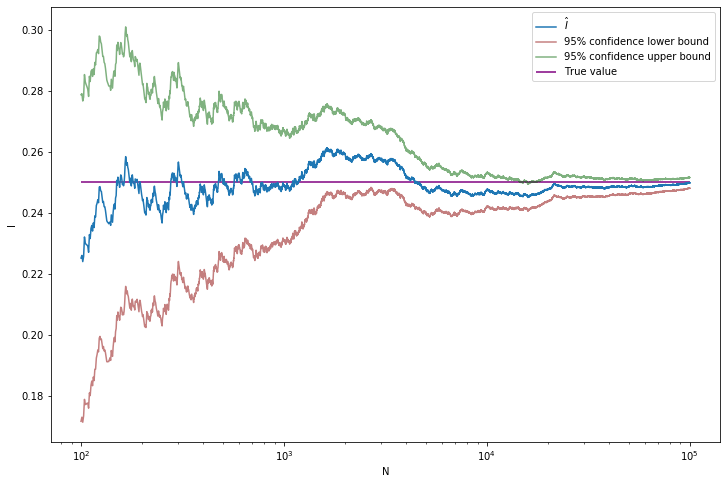

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

nn = np.arange(100, N + 1)

plt.figure(figsize=(12, 8))
plt.plot(nn, I_hat[nn - 1], label=r'$\hat{I}$')
plt.plot(nn, I_lower[nn - 1], label='95% confidence lower bound', color='darkred', alpha=0.5)
plt.plot(nn, I_upper[nn - 1], label='95% confidence upper bound', color='darkgreen', alpha=0.5)
plt.hlines(true_value, xmin=min(nn), xmax=max(nn), label='True value', color='purple')
plt.xlabel('N')
plt.ylabel('I')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

**Example 25.2**.  Let

$$ f(x) = \frac{1}{\sqrt{2 \pi}} e^{-x^2 / 2} $$

be the standard normal PDF.  Suppose we want to compute the CDF at some point,

$$ I = \int_{-\infty}^x f(s) ds = \Phi(x) $$

Of course, you could look up the value in a table or a computing library, but let's use the simulation method instead.

In [3]:
import numpy as np
import numpy as np
from scipy.stats import norm
from tqdm import tqdm_notebook

np.random.seed(0)

N = 100000

true_value = norm.cdf(2)

def h(x):
    return np.where(x < 2, 1, 0)

X = np.random.normal(loc=0.0, scale=1.0, size=N)
Y = h(X)

I_hat = np.empty(N)
se_hat = np.empty(N)
for n in tqdm_notebook(range(N)):
    I_hat[n] = Y[:n+1].mean()
    if n < 2:
        se_hat[n] = np.inf
    else:
        s2 = np.sum((Y[:n+1] - I_hat[n])**2) / n
        se_hat[n] = np.sqrt(s2 / (n + 1))
        
z = norm.ppf(0.975)

I_lower = I_hat - z * se_hat
I_upper = I_hat + z * se_hat

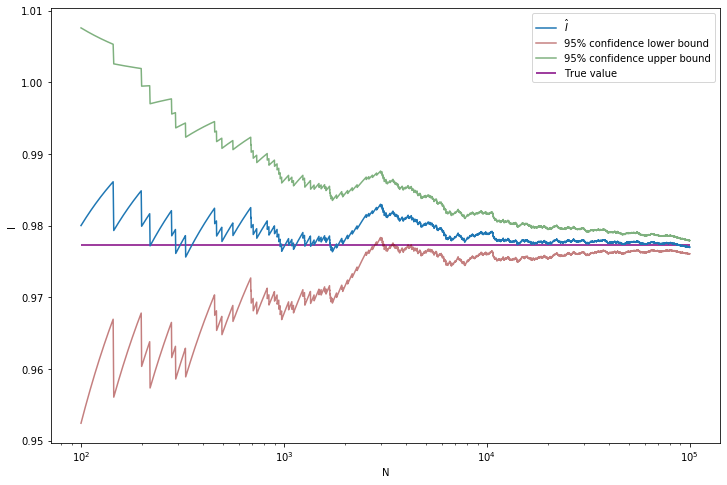

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

nn = np.arange(100, N + 1)

plt.figure(figsize=(12, 8))
plt.plot(nn, I_hat[nn - 1], label=r'$\hat{I}$')
plt.plot(nn, I_lower[nn - 1], label='95% confidence lower bound', color='darkred', alpha=0.5)
plt.plot(nn, I_upper[nn - 1], label='95% confidence upper bound', color='darkgreen', alpha=0.5)
plt.hlines(true_value, xmin=min(nn), xmax=max(nn), label='True value', color='purple')
plt.xlabel('N')
plt.ylabel('I')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

**Example 25.3 (Two Binomials)**.  Let $X \sim \text{Binomial}(n, p_1)$ and $Y \sim \text{Binomial}(n, p_2)$.  We would like to estimate $\delta = p_2 - p_1$.  The MLE is $\hat{\theta} = \hat{p}_2 - \hat{p}_1 = (Y / m) - (X / n)$.  We can get the standard error $\hat{\text{se}}$ using the delta method which yields

$$ \hat{\text{se}} = \sqrt{\frac{\hat{p}_1 (1 - \hat{p}_1)}{n} + \frac{\hat{p}_2 (1 - \hat{p}_2)}{m}} $$

and then construct a confidence interval using $\hat{\delta} \pm z_{\alpha / 2} \hat{\text{se}} $.  Now consider a Bayesian analysis.  Suppose we use the prior $f(p_1, p_2) = f(p_1) f(p_2) = 1$, that is, a flat prior on $(p_1, p_2)$.  The posterior is

$$ f(p_1, p_2 | X, Y) \propto p_1^{X} (1 - p_1)^{n - X} p_2^Y (1 - p_2)^{m - Y}$$

The posterior mean of $\delta$ is

$$ \overline{\delta} = \int_0^1 \int_0^1 \delta(p_1, p_2) f(p_1, p_2 | X, Y) \; dp_1 dp_2 = \int_0^1 \int_0^1 (p_2 - p_1) f(p_1, p_2 | X, Y) \; dp_1 dp_2 $$

If we want the posterior density of $\delta$ we can first get the posterior CDF

$$ F(c | X, Y) = \mathbb{P}(\delta \leq c | X, Y) = \int_A f(p_1, p_2 | X, Y) \; dA $$

where $A = \{ (p_1, p_2) : p_2 - p_1 \leq c \}$.  The density can then be obtained by differentiating $F$.

To avoid these integrals, let's use simulation.  Note that $f(p_1, p_2 | X, Y) = f(p_1 | X) f(p_2 | Y)$ which implies that $p_1$ and $p_2$ are independent under the posterior distribution.  Also, we see that

$$ 
p_1 | X \sim \text{Beta}(X + 1, n - X + 1) 
\quad \text{and} \quad
p_2 | Y \sim \text{Beta}(Y + 1, m - Y + 1) 
$$

Hence, we can simulate $(P_1^{(1)}, P_2^{(1)}), \dots, (P_1^{(N)}, P_2^{(N)})$ by drawing

$$ 
P_1^{(i)} \sim \text{Beta}(X + 1, n - X + 1) 
\quad \text{and} \quad
P_2^{(i)} \sim \text{Beta}(Y + 1, m - Y + 1) 
$$

Now let $\delta^{(i)} = P_2^{(i)} - P_1^{(i)}$.  Then,

$$ \overline{\delta} \approx \frac{1}{N} \sum_i \delta^{(i)} $$

We can also get a 95% posterior interval for $\delta$ by sorting the simulated values, and finding the 2.5% and 97.5% quantiles.  The posterior density $f(\delta | X, Y)$ can be obtained by applying density estimation techniques to the $\delta^{(i)}$ or by simply plotting a histogram.

For example, assume $n = m = 10$, $X = 8$ and $Y = 6$.

In [5]:
import numpy as np
from tqdm import tqdm_notebook

n, m = 10, 10
X, Y = 8, 6

N = 100000

np.random.seed(0)
P1 = np.random.beta(X + 1, n - X + 1, size=N)
P2 = np.random.beta(Y + 1, m - Y + 1, size=N)
delta = P2 - P1

delta_mean = np.empty(N)
delta_lower = np.empty(N)
delta_upper = np.empty(N)
for n in tqdm_notebook(range(N)):
    delta_mean[n] = delta[:n+1].mean()
    if n < 2:
        delta_lower[n], delta_upper[n] = np.inf, np.inf
    else:
        delta_lower[n], delta_upper[n] = np.quantile(delta[:n+1], [0.025, 0.975])

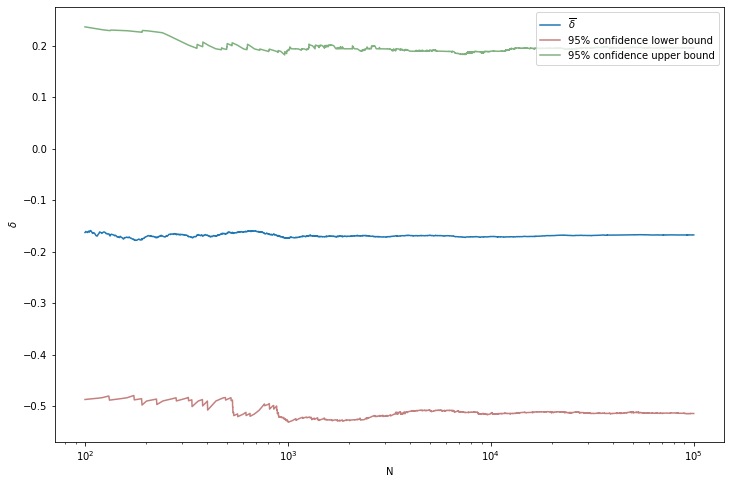

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

nn = np.arange(100, N + 1)

plt.figure(figsize=(12, 8))
plt.plot(nn, delta_mean[nn - 1], label=r'$\overline{\delta}$')
plt.plot(nn, delta_lower[nn - 1], label='95% confidence lower bound', color='darkred', alpha=0.5)
plt.plot(nn, delta_upper[nn - 1], label='95% confidence upper bound', color='darkgreen', alpha=0.5)
plt.xlabel('N')
plt.ylabel(r'$\delta$')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

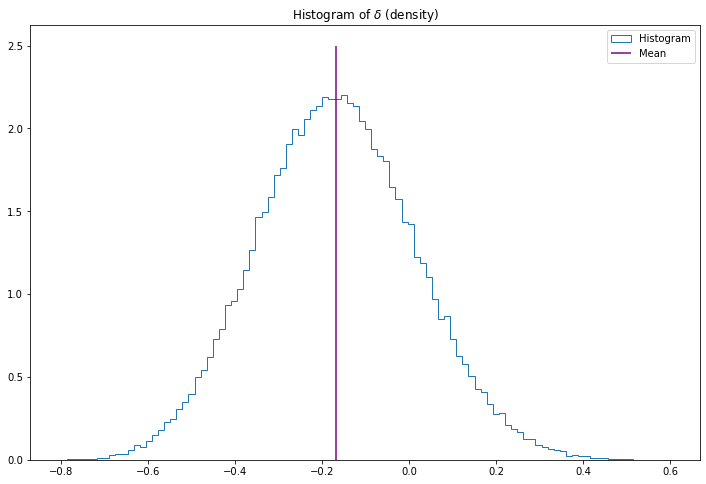

In [7]:
plt.figure(figsize=(12, 8))
plt.hist(delta, bins=100, histtype='step', density=True, label='Histogram')
plt.vlines(delta.mean(), ymin=0, ymax=2.5, label='Mean', color='purple')
plt.title('Histogram of $\delta$ (density)')
plt.legend(loc='upper right')
plt.show()

**Example 25.4 (Dose Response)**.  Suppose we conduct an experiment by giving rats one of ten possible doses of a drug, denoted by $x_1 < x_2 < \cdots < x_{10}$.  For each dose level $x$, we use $n$ rats and observe $Y_i$, the number that die.  Thus we have 10 independent binomials $Y_i \sim \text{Binomial}(n, p_i)$.  Suppose we know from biological considerations that higher doses should have higher probability of death.  Thus, $p_1 \leq p_2 \leq \cdots \leq p_{10}$.  Suppose we want to estimate the dose at which animals have a 50% chance of dying.  This is called the LD50.  Formally, $\delta = x_j$ where

$$ j = \min \{ i: p_i \geq .50 \} $$

Notice that $\delta$ is implicitly a (complicated) function of $p_1, \dots, p_{10}$ so we can write $\delta = g(p_1, \dots, p_{10})$ for some $g$.  This just means that if we know the $p_i$ then we can find $\delta$.  The posterior mean of $\delta$ is

$$ \overline{\delta} = \int \int \cdots \int_A g(p_1, \dots, p_{10}) f(p_1, \dots, p_{10} | Y_1, \dots, Y_{10} ) \; dp_1 dp_2 \dots dp_{10} $$

The integral is over the region of valid parameter values,

$$ A = \{ (p_1, \dots, p_{10}) : p_1 \leq \cdots \leq p_{10} \} $$

Similarly, the posterior CDF of $\delta$ is

$$
F(c | Y_1, \dots, Y_{10}) = \mathbb{P}(\delta \leq c | Y_1, \dots, Y_{10}) = \int \int \cdots \int_B f(p_1, \dots, p_{10} | Y_1, \dots, Y_{10} ) \; dp_1 dp_2 \dots dp_{10}
$$

where the integral is over the valid parameter values given $ \delta \leq c$,

$$ B = A \cap \{ (p_1, \dots, p_{10}) : g(p_1, \dots, p_{10}) \leq c \} $$

We would need to do a 10 dimensional integral over a restricted region $A$.  Instead, let's use simulation.

Let us take a flat prior truncated over $A$.  Except for the truncation, each $P_i$ has once again a Beta distribution.  To draw from the posterior, we do the following steps:

- Draw $P_i \sim \text{Beta}(Y_i + 1, n - Y_i + 1)$, $i = 1, \dots, 10$.
- If $P_1 \leq P_2 \leq \cdots \leq P_{10}$ keep this draw.  Otherwise, throw it away and draw again until you get one you can keep.
- Let $\delta = x_j$ where $j = \min \{ i : P_i > .50 \}$.

We repeat this $N$ times to get $\delta^{(1)}, \dots, \delta^{(N)}$ and take

$$ \mathbb{E}(\delta | Y_1, \dots, Y_{10}) \approx \frac{1}{N} \sum_i \delta^{(i)} $$

$\delta$ is a discrete variable.  We can estimate its probability mass function by 

$$ \mathbb{P}(\delta = x_j | Y_1, \dots, Y_10) \approx \frac{1}{N} I(\delta^{(i)} = j) $$

In [8]:
import numpy as np

n = np.repeat(15, 10)
X = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
Y = np.array([0, 1, 2, 6, 5, 12, 15, 15, 15, 15])

In [9]:
N = 1000000
p = np.empty((N, 10))
check = np.empty(N, dtype=bool)

np.random.seed(0)
for i in range(10):
    p[:, i] = np.random.beta(Y[i] + 1, n[i] - Y[i] + 1, size=N)
    
check = np.min(np.diff(p), axis=1) >= 0

p = p[check]
N = p.shape[0]

delta = np.empty(N)
for i in range(N):
    delta[i] = X[np.argmax(np.cumsum(p[i, :]) > 0.5)]

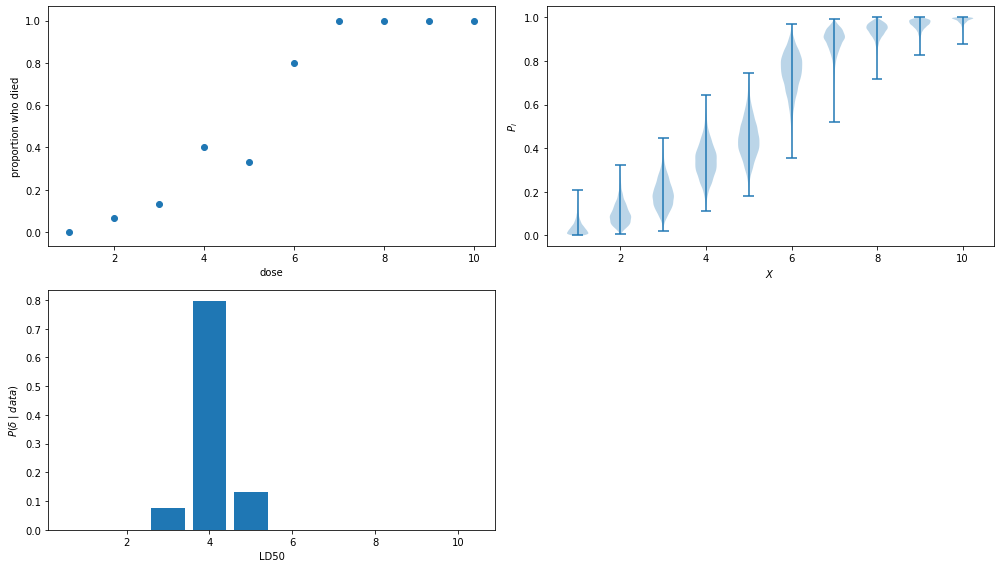

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 8))

ax = plt.subplot(2, 2, 1)
ax.scatter(X, Y / n)
ax.set_xlabel('dose')
ax.set_ylabel('proportion who died')

ax = plt.subplot(2, 2, 2)
ax.violinplot(p)
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$P_i$')

ax = plt.subplot(2, 2, 3)
ax.bar(X, [(sum(delta == i) / N) for i in X])
ax.set_xlabel('LD50')
ax.set_ylabel('$P(\delta \;|\; data)$')

plt.tight_layout()
plt.show()

### 25.3 Importance Sampling

Consider the integral $I = \int h(x) f(x) dx$ where $f$ is a probability density.  The basic Monte Carlo method involves sampling from $f$.  However, there are cases where we may not know how to sample from $f$.  For example, in Bayesian inference, the posterior density is obtained by multiplying the likelihood $\mathcal{L}(\theta)$ times the prior $f(\theta)$.  There is no guarantee that $f(\theta | x)$ will be a known distribution, such as a Normal or a Gamma.

Importance sampling is a generalization of basic Monte Carlo which overcomes this problem.  Let $g$ be a probability density that we know how to simulate from.  Then

$$ I = \int h(x) f(x) \; dx = \int \frac{h(x) f(x)}{g(x)} g(x) \; dx  = \mathbb{E}_g[Y] $$

where $Y = h(X) f(X) / g(X)$ and the expectation $\mathbb{E}_g[Y]$ is with respect to $g$.  We can simulate $X_1, \dots, X_N \sim g$ and estimate $I$ by

$$ \hat{I} = \frac{1}{N} \sum_i Y_i = \frac{1}{N} \sum_i \frac{h(X_i) f(X_i)}{g(X_i)} $$

This is called **importance sampling**. By the law of large numbers, $\hat{I} \xrightarrow{\text{P}} I$.  However, there is a catch.  It's possible that $\hat{I}$ might have an infinite standard error.  To see why, recall that $I$ is the mean of $w(x) = h(x) f(x) / g(x)$.  The second moment of this quantity is

$$ \mathbb{E}_g[w^2(X)] = \int \left( \frac{h(x) f(x)}{g(x)} \right)^2 g(x) \; dx = \int \frac{h^2(x) f^2(x)}{g(x)} \; dx$$

If $g$ has thinner tails than $f$, this integral might be infinite.  To avoid this, a basic rule in importance sampling is to sample from a density $g$ with thicker tails than $f$.  Also, suppose that $g(x)$ is small over some set $A$ where $f(x)$ is large.  Again, the ratio of $f / g$ could be large leading to a large variance.  This implies that we should $g$ to be similar in shape to $f$.  In summary, a good choice for an importance sampling density $g$ should be similar to $f$ but with thicker tails.  In fact, we can say what the optimal choice of $g$ is.

**Theorem 25.5**.  The choice of $g$ that minimizes the variance of $\hat{I}$ is

$$ g^*(x) = \frac{|h(x)| f(x) }{\int | h(s) | f(s)  ds} $$

**Proof**.  The variance of $w = f h / g$ is:

$$
\begin{align}
\mathbb{E}_g[w^2] - (\mathbb{E}_g[w])^2 &= \int w^2(x) g(x) dx - \left( \int w(x) g(x) dx \right)^2 \\
&= \int \frac{h^2(x) f^2(x)}{g^2(x)} g(x) dx - \left( \int \frac{h(x) f(x)}{g(x)} g(x) dx \right)^2 \\
&= \int \frac{h^2(x) f^2(x)}{g^2(x)} g(x) dx - \left( \int h(x) f(x) dx \right)^2
\end{align}
$$

The second integral does not depend on $g$ so we only need to minimize the first integral.  Now, from Jensen's inequality we have

$$ \mathbb{E}_g[W^2] \geq \left(\mathbb{E}_g[|W|]\right)^2 = \left( \int |h(x)| f(x) dx \right)^2 $$

This establishes a lower bound on $\mathbb{E}_g[W^2]$.  However, $\mathbb{E}_{g^*}[W^2]$ equals this lower bound, which proves the claim.

This theorem is interesting but only of theoretical interest.  If we did not know how to sample from $f$ then it is unlikely that we could sample from $g^*$.  In practice, we try to find a thick tailed distribution $g$ which is similar to $f |h|$.

**Example 25.6 (Tail Probability)**.  Let's estimate

$$ I = \mathbb{P}(Z > 3) \approx .0013
\quad \text{where } Z \sim N(0, 1)$$

Using the basic Monte Carlo estimator,

$$ I = \int h(x) f(x) \; dx \quad \text{where} \quad h(x) = I(x > 3), f \sim N(0, 1)$$

and $$ \hat{I} = \frac{1}{N} \sum_i h(X_i) $$

In [11]:
import numpy as np
import numpy as np
from scipy.stats import norm
from tqdm import tqdm_notebook

np.random.seed(0)

B = 1000000
N = 100

true_value = 1 - norm.cdf(3)

def h(x):
    return np.where(x > 3, 1, 0)

I_bootstrap = np.empty(B)
for b in tqdm_notebook(range(B)):
    XX = np.random.normal(loc=0.0, scale=1.0, size=N)
    YY = h(XX)
    I_bootstrap[b] = YY.mean()

E_I = I_bootstrap.mean()
SE_I = I_bootstrap.std()

print('Expected value of I: \t %.5f' % E_I)
print('Standard error of I: \t %.5f' % SE_I)


Expected value of I: 	 0.00135
Standard error of I: 	 0.00368


Using importance sampling with $g \sim N(4, 1)$, we get

$$ I = \int \frac{h(x) f(x)}{g(x)} g(x) dx
\quad \text{where} \quad h(x) = I(x > 3), f \sim N(0, 1), g \sim N(4, 1)$$
and

$$ \hat{I} = \frac{1}{N} \sum_i \frac{f(X_i) h(X_i)}{g(X_i)} $$

In [12]:
import numpy as np
import numpy as np
from scipy.stats import norm
from tqdm import tqdm_notebook

np.random.seed(0)

B = 1000000
N = 100

true_value = 1 - norm.cdf(3)

def h(x):
    return np.where(x > 3, 1, 0)

def f_over_g(x):
    return np.exp(-(1/2) * (x**2 - (x - 4)**2))

I_bootstrap = np.empty(B)
for b in tqdm_notebook(range(B)):
    XX = np.random.normal(loc=4.0, scale=1.0, size=N)
    YY = h(XX) * f_over_g(XX)
    I_bootstrap[b] = YY.mean()

E_I = I_bootstrap.mean()
SE_I = I_bootstrap.std()

print('Expected value of I: \t %.5f' % E_I)
print('Standard error of I: \t %.5f' % SE_I)


Expected value of I: 	 0.00135
Standard error of I: 	 0.00031


Note we have reduced the standard error by an order of magnitude.

**Example 25.7 (Measurement Model with Outliers)**.  Suppose we have measurements $X_1, \dots, X_n$ of some physical quantity $\theta$.  We might model this as

$$ X_i = \theta + \epsilon_i $$

If we assume that $\epsilon_i \sim N(0, 1)$ then $X_i \sim N(\theta_i, 1)$.  However, when taking measurements, it is often the case that we get the occasional wild observation, or outlier.  This suggests that a Normal might be a poor model since Normals have thin tails which implies that extreme observations are rare.  One way to improve this model is to use a density for $\epsilon_i$ with a thicker tail, for example, at t-distribution with $\nu$ degrees of freedom which has the form

$$ t(x) = \frac{\Gamma\left( \frac{\nu + 1}{2} \right)}{\Gamma \left( \frac{\nu}{2} \right)} \frac{1}{\nu \pi} \left( 1 + \frac{x^2}{\nu} \right)^{-(\nu + 1) / 2}$$

Smaller values of $\nu$ correspond to thicker tails.  For sake of illustration we will take $\nu = 3$.  Suppose we observe $n$ $X_i = \theta + \epsilon_i$, $i = 1, \dots, n$ where $\epsilon_i$ has a t-distribution with $\nu = 3$.  We will take a flat prior on $\theta$.  The likelihood is $\mathcal{L}(\theta) = \prod_{i=1}^n t(X_i - \theta)$ and the posterior mean of $\theta$ is

$$ \overline{\theta} = \frac{\int \theta \mathcal{L}(\theta) \; d\theta }{\int \mathcal{L}(\theta) \; d\theta} $$

We can estimate the top and bottom integral using importance sampling.  We draw $\theta_1, \dots, \theta_N \sim g$ and then

$$ \overline{\theta} \approx \frac{ \frac{1}{N} \sum_{j=1}^n \frac{\theta_j \mathcal{L}(\theta_j)}{g(\theta_j)}}{\frac{1}{N} \sum_{j=1}^n \frac{\mathcal{L}(\theta_j)}{g(\theta_j)}} $$

### 25.4 MCMC Part I: The Metropolis-Hastings Algorithm

Consider again the problem of estimating the integral $I = \int h(x) f(x) dx$.  In this chapter we introduce the Markov chain Monte Carlo (MCMC) methods.  The idea is to construct a Markov chain $X_1, X_2, \dots$ whose stationary distribution is $f$.  Under certain conditions it will then follow that

$$ \frac{1}{N} \sum_{i=1}^N h(X_i) \xrightarrow{\text{P}} \mathbb{E}_f[h(x)] = I $$

This works because there is a law of large numbers for Markov chains called **the ergodic theorem**.

The **Metropolis-Hastings** algorithm is a specific MCMC method that works as follows.  Let $q(y | x)$ be an arbitrary, friendly distribution (i.e. we know how to sample from $q(y | x)$).  The conditional density $q(y | x)$ is called the **proposal distribution**.  The algorithm creates a sequence of observations as follows.

**Metropolis-Hastings Algorithm**.  

Choose $X_0$ arbitrarily.  Suppose we have generated $X_0, X_1, \dots, X_i$.  To generate $X_{i+1}$ do:

1. Generate a **proposal** or **candidate** value $Y \sim q(y | X_i)$.
2. Evaluate $r \equiv r(X_i, Y)$ where

$$ r(x, y) = \min \left\{ \frac{f(y)}{f(x)} \frac{q(x | y)}{q(y | x)}, 1 \right\} $$

3. Set

$$
X_{i+1} = \begin{cases}
Y   &\text{with probability } r \\
X_i &\text{with probability } 1 - r 
\end{cases}
$$

*Remark 1*:  A simple way of executing step 3 is to generate $U \sim \text{Uniform}(0, 1)$, then if $U < r$ set $X_{i + 1} = Y$ else set $X_{i + 1} = X_i$.

*Remark 2*:  A common choice for $q(y | x)$ is $N(x, b^2)$ for some $b > 0$.  This means that the proposal is drawn from a Normal centered at the current value.

*Remark 3*:  if the proposal density $q$ is symmetric, $q(x | y) = q(y | x)$, then $r$ simplifies to

$$ r = \min \left\{ \frac{f(Y)}{f(X_i)}, 1\right\} $$

The Normal proposal distribution in remark 2 is an example of a symmetric proposal density.

By construction, $X_0, X_1, \dots$ is a Markov chain.  But why does this Markov chain have $f$ as its stationary distribution?  Before we explain why, let's do an example.

**Example 25.8**.  The Cauchy distribution has density

$$ f(x) = \frac{1}{\pi} \frac{1}{1 + x^2} $$

Our goal is to simulate a Markov chain whose stationary distribution is $f$.  As suggested in the remark above, we take $q(y | x)$ to be a $N(x, b^2)$.  So in this case,

$$ r(x, y) = \min \left\{ \frac{f(y)}{f(x)}, 1 \right\} = \min \left\{ \frac{1 + x^2}{1 + y^2} , 1\right\} $$

So the algorithm is to draw $Y \sim N(X_i, b^2)$ and set

$$ 
X_{i + 1} = \begin{cases}
Y & \text{with probability } r(X_i, Y) \\
X & \text{with probability } 1 - r(X_i, Y)
\end{cases} 
$$

The simulator requires a choice of $b$.  Let's plot 3 chains of length 1000 using $b = .1$, $b = 1$ and $b = 10$, as well as their histograms.

In [13]:
import numpy as np

def generate_chain(X0=0, N=1000, b=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    U = np.random.uniform(low=0, high=1, size=N)
    XX = np.empty(N + 1)
    XX[0] = X0
    for i in range(1, N + 1):
        Xi = XX[i - 1]
        Y = np.random.normal(loc=Xi, scale=b)
        r = min((1 + Xi**2) / (1 + Y**2), 1)
        XX[i] = Y if U[i - 1] < r else Xi
        
    return XX

In [14]:
N = 1000
values = [
    generate_chain(b=0.1, N=N, seed=0),
    generate_chain(b=1, N=N, seed=0),
    generate_chain(b=10, N=N, seed=0)
]

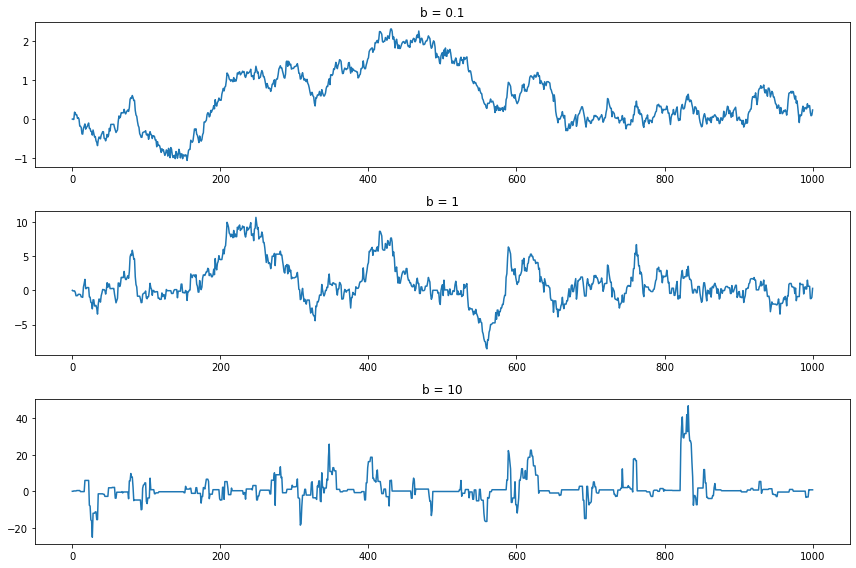

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8))

nn = np.arange(0, N + 1)

ax = plt.subplot(3, 1, 1)
ax.plot(nn, values[0])
ax.set_title('b = 0.1')

ax = plt.subplot(3, 1, 2)
ax.plot(nn, values[1])
ax.set_title('b = 1')

ax = plt.subplot(3, 1, 3)
ax.plot(nn, values[2])
ax.set_title('b = 10')

plt.tight_layout()
plt.show()

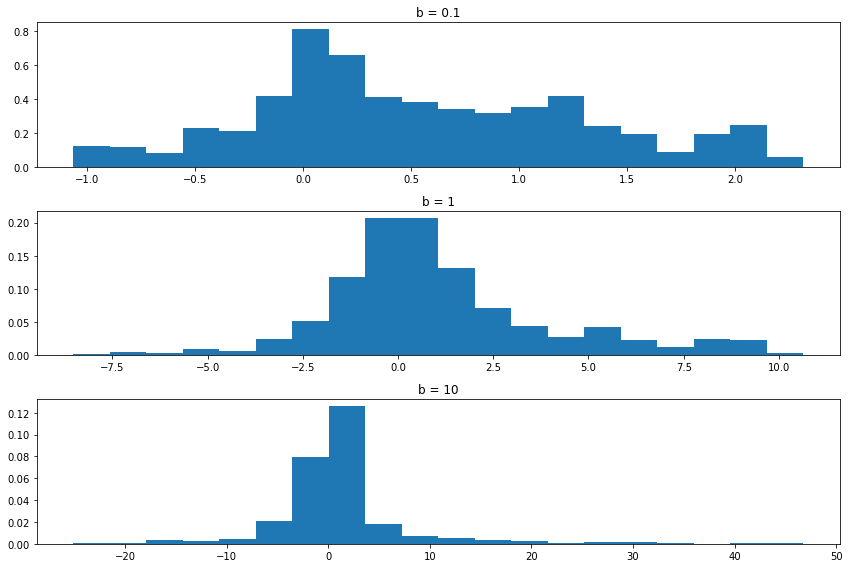

In [16]:
plt.figure(figsize=(12, 8))

N = 1000
nn = np.arange(0, N + 1)

ax = plt.subplot(3, 1, 1)
ax.hist(values[0], density=True, bins=20)
ax.set_title('b = 0.1')

ax = plt.subplot(3, 1, 2)
ax.hist(values[1], density=True, bins=20)
ax.set_title('b = 1')

ax = plt.subplot(3, 1, 3)
ax.hist(values[2], density=True, bins=20)
ax.set_title('b = 10')

plt.tight_layout()
plt.show()

Setting $b = 0.1$ forces the chain to take small steps.  As a result, the chain doesn't "explore" much of the sample space.  The histogram from the sample does not approximate the true density very well.  Setting $b = 10$ causes the proposals to often be in the tails, making $r$ small and hence we reject the proposal and keep the chain at the current position.  The result is that the chain "gets stuck" at the same place often.  Again, this means that the histogram does not approximate the true density well.  The middle choice avoids both extremes and results in a Markov chain sample that better represents the density sooner.  In summary, there are turning parameters and the efficiency of the chain depends on these parameters.  We'll discuss this in more detail later.

If the sample of the Markov chain starts to "look like" the target distribution $f$ quickly, then we say that the chain is "mixing well".  Constructing a chain that mixes well is somewhat of an art.

**Why it works**.  Recall from the previous chapter that a distribution $\pi$ satisfies **detailed balance** for a Markov chain if

$$ p_{ij} \pi_i = p_{ji} \pi_j $$

We then showed that if $\pi$ satisties detailed balance, then it is a stationary distribution for the chain.

Because we are now dealing with continuous state Markov chains, we will change notation a little and write $p(x, y)$ for the probability of making a transition from $x$ to $y$.   Also, let's use $f(x)$ instead of $\pi$ for a distribution.  In this notation, $f$ is a stationary distribution if $f(x) = \int f(y) p(y, x) dx$ and detailed balance holds for $f$ if

$$ f(x) p(x, y) = f(y) p(y, x) $$

Detailed balance implies that $f$ is a stationary distribution since, if detailed balance holds, then

$$ \int f(y) p(y, x) dx = \int f(x) p(x, y) dy = f(x) \int p(x, y) dy = f(x) $$

which shows that $f(x) = \int f(y) p(y, x) dx$ as required.  Our goal is to show that $f$ satisfies detailed balance, which will imply that $f$ is a stationary distribution for the chain.

Consider two points $x$ and $y$.  Either

$$
f(x) q(y | x) < f(y) q(y | x)
\quad \text{or} \quad
f(x) q(y | x) > f(x) q(y | x)
$$

We will ignore ties which we can do in the continuous setting.  Without loss of generality, assume that $f(x) q(y | x) > f(y) q(y | x)$.  This implies that

$$ r(x, y) = \frac{f(y)}{f(x)} \frac{q(x | y)}{q(y | x)} 
\quad \text{and} \quad
r(y, x) = 1
$$

Now $p(x, y)$ is the probability of jumping from $x$ to $y$.  This requires two things: (i) the proposal distribution must generate $y$ and (ii) we must accept $y$.  Thus,

$$ p(x, y) = q(y | x) r(x, y) =  q(y | x) \frac{f(y)}{f(x)} \frac{q(x | y)}{q(y | x)} = \frac{f(y)}{f(x)} q(x | y)$$

Therefore,

$$ f(x) p(x, y) = f(y) q(x | y) $$

On the other hand, $p(y, x)$ is the probability of jumping from $y$ to $x$.  This requires two things: (i) the proposal distribution must generate $x$ and (ii) we must accept $x$.  This occurs with probability $p(y, x) = q(x | y) r(y, x) = q(x | y)$.  Hence,

$$ f(y) p(y, x) = f(y) q(x | y) $$

Comparing the two last statements, we get that detailed balance holds:

$$ f(x) p(x, y) = f(y) q(x | y) = f(y) p(y, x) $$

### 25.5 MCMC Part II: Different Flavors

There are a few different types of MCMC algorithm.  Here we will consider a few of the most popular versions.

#### Random-Walk Metropolis-Hastings

In the previous section we considered drawing a proposal $Y$ of the form

$$ Y = X + \epsilon_i $$

where $\epsilon_i$ comes from some distribution with density $g$.  In other words, $q(y | x) = g(y - x)$.  We saw that, in this case,

$$ r(x, y) = \min \left\{ \frac{f(y)}{f(x)}, 1 \right\} $$

This is called a **random-walk-Metropolis-Hastings method**.  The reason for name is that, if we did not do the accept-reject step, we would be simulating a random walk.  The most common choice for $g$ is $N(0, b^2)$.  The hard part is choosing $b$ so that the chain mixes well.  A good rule of thumb is:  choose $b$ so that you accept the proposals about 50% of the time.

**Warning**:  This method doesn't make sense unless $X$ takes values on the whole real line.  If $X$ is restricted to some interval then it is best to transform $X$, say, $Y = m(X)$ where $Y$ takes values on the whole real line.  For example, if $X \in (0, \infty)$ then you might do $Y = \log X$ and simulate the distribution for $Y$ instead of $X$.

#### Independence-Metropolis-Hastings

This is an importance-sampling version of the MCMC.  In this we draw a proposal from a fixed distribution $g$.  Generally $g$ is chosen to be an approximation to $f$.  The acceptance probability becomes

$$ r(x, y) = \min \left\{ 1, \frac{f(y)}{f(x)} \frac{g(x)}{g(y)} \right\} $$

#### Gibbs Sampling

The two previous methods can be easily adapted, in principle, to work in higher dimensions.  In practice, tuning the chains to make them mix well is hard.  Gibbs sampling is a way to turn a high-dimensional problem into several one dimensional problems.

Here's how it works for a bivariate problem.  Suppose that $(X, Y)$ has density $f_{X, Y}(x, y)$.  First, suppose that it is possible to simulate from the conditional distributions $f_{X|Y}(x | y)$ and $f_{Y | X}(y | x)$.  Let $(X_0, Y_0)$ be the starting values.  Assume we have drawn $(X_0, Y_0), \dots, (X_n, Y_n)$.  Then the Gibbs sampling algorithm for getting $(X_{n+1}, Y_{n+1})$ is:

$$
\begin{align}
X_{n + 1} &\sim f_{X|Y}(x | Y_n) \\
Y_{n + 1} &\sim f_{Y|X}(y | X_{n + 1})
\end{align}
$$

This generalizes in the obvious ways to higher dimensions.

**Example 25.9 (Normal Hierarchical Model)**.  Gibbs sampling is very useful for a class of models called **hierarchical models**.  Here is a simple case.  Suppose we draw a sample of $k$ cities.  From each city we draw $n_i$ people and observe how many people $Y_i$ have a disease.  Thus, $Y_i \sim \text{Binomial}(n_i, p_i)$.  We are allowing for different disease rates in different cities.  We can also think of the $p_i$'s as random draws from some distribution $F$.  We can write this model in the following way:

$$
\begin{align}
P_i &\sim F \\
Y_i | P_i = p_i &\sim \text{Binomial}(n_i, p_i)
\end{align}
$$

We are interested in estimating the $p_i$'s and the overall disease rate $\int p \; dF(p)$.

To proceed, it will simplify matters if we make some transformations that will allow us to use some Normal approximations.  Let $\hat{p}_i = Y_i / n_i$.  Recall that $\hat{p}_i \approx N(p_i, s_i)$ where $s_i = \sqrt{\hat{p}_i (1 - \hat{p}_i) / n_i}$.  Let $\psi_i = \log (p_i / (1 - p_i))$ and define $Z_i \equiv \hat{\psi}_i = \log (\hat{p}_i / (1 - \hat{p}_i))$.  By the delta method,

$$ \hat{\psi}_i \approx N(\psi_i, \sigma_i^2) \quad \text{where} \quad \sigma_i^2 = \frac{1}{n \hat{p}_i (1 - \hat{p}_i)}$$

Experience shows that the normal approximation for $\psi$ is more accurate than the normal approximation for $p$ so we shall work with $\psi$.  We shall treat the $\sigma_i$ as known.  Furthermore, we shall take the distribution of the $\psi_i$'s to be normal.  The hierarchical model is now

$$
\begin{align}
\psi_i &\sim N(\mu, \tau^2) \\
Z_i | \psi_i &\sim N(\psi_i, \sigma_i^2)
\end{align}
$$

As yet another simplication we take $\tau = 1$.  The unknown parameters are $\theta = (\mu, \psi_1, \dots, \psi_k)$.  The likelihood function is

$$ 
\begin{align}
\mathcal{L}(\theta) 
&\propto \prod_i f(\psi_i | \mu) \prod_i f(Z_i | \psi) \\
&\propto \prod _i \exp \left\{-\frac{1}{2} (\psi_i - \mu)^2 \right\} \exp \left\{ -\frac{1}{2} (Z_i - \psi_i)^2 \right\}
\end{align}
$$

If we use the prior $f(\mu) \propto 1$ then the posterior is proportional to the likelihood.  To use Gibbs sampling, we need to find the conditional distribution of each parameter conditional on all the others.  Let us begin by finding $f(\mu | \text{rest})$ where "rest" refers to all the other variables.  We can throw away terms that don't involve $\mu$.  Thus,

$$ f(\mu | \text{rest}) \propto \prod_i \exp \left\{ -\frac{1}{2} (\psi_i - \mu)^2 \right\} \propto \exp \left\{ -\frac{k}{2} (\mu - b)^2 \right\} $$ 

where 

$$ b = \frac{1}{k} \sum_i \psi_i $$

Hence we see that $\mu | \text{rest} \sim N(b, 1 / k)$.

Next we will find $f(\psi | \text{rest})$.  Again, we can throw away any terms not involving $\psi_i$, leaving us with

$$ f(\psi_i | \text{rest}) \propto \exp \left\{-\frac{1}{2} (\psi_i - \mu)^2 \right\} \exp \left\{ -\frac{1}{2} (Z_i - \psi_i)^2 \right\} \propto \exp \left\{ -\frac{1}{2d_i^2}(\psi_i - e_i)^2 \right\} $$

where

$$ 
e_i = \frac{\frac{Z_i}{\sigma_i^2} + \mu}{1 + \frac{1}{\sigma_i^2}}
\quad \text{and} \quad
d_i^2 = \frac{1}{1 + \frac{1}{\sigma_i^2}}
$$

and so $\psi_i | \text{rest} \sim N(e_i, d_i^2)$.

The Gibbs sampling algorithm then involves iterating the following steps $N$ times:

$$
\begin{align}
\text{draw } \mu &\sim N(b, v^2) \\
\text{draw } \psi_1 &\sim N(e_1, d_1^2) \\
\vdots & \quad \vdots \\
\text{draw } \psi_k &\sim N(e_k, d_k^2)
\end{align}
$$

It is understood that, at each step, the most recent version of each variable is used.

Let us now consider a numeric example.  Suppose there are $k = 20$ cities and we sample $n_i = 20$ people from each city.

In [17]:
import numpy as np

def gibbs(y, n, N):
    k = len(y)
    p_hat = y / n
    Z = np.log(p_hat / (1 - p_hat))
    sigma2 = 1 / (n * p_hat * (1 - p_hat))
    v = np.sqrt(1 / np.sum(1 / sigma2))
    mu = np.zeros(N)
    psi = np.zeros((N, k))
    
    for i in range(1, N):
        # draw mu given rest
        b = v**2 * np.sum(psi[i - 1, :] / sigma2)
        mu[i] = np.random.normal(loc=b, scale=v)
        
        # draw psi given rest
        e = (Z + mu[i] / sigma2) / (1 + (1 / sigma2))
        d = np.sqrt(1 / (1 + (1 / sigma2)))
        psi[i, :] = np.random.normal(loc=e, scale=d)
        
    p = 1 - (1 / (1 + np.exp(psi)))
    return {
        'mu': mu,
        'psi': psi,
        'p': p
    }

In [18]:
np.random.seed(0)

true_p = np.arange(5, 15, step=0.25) / 20
np.random.shuffle(true_p)
Y = np.random.binomial(20, true_p)

N = 1000
results = gibbs(Y, 20, N)

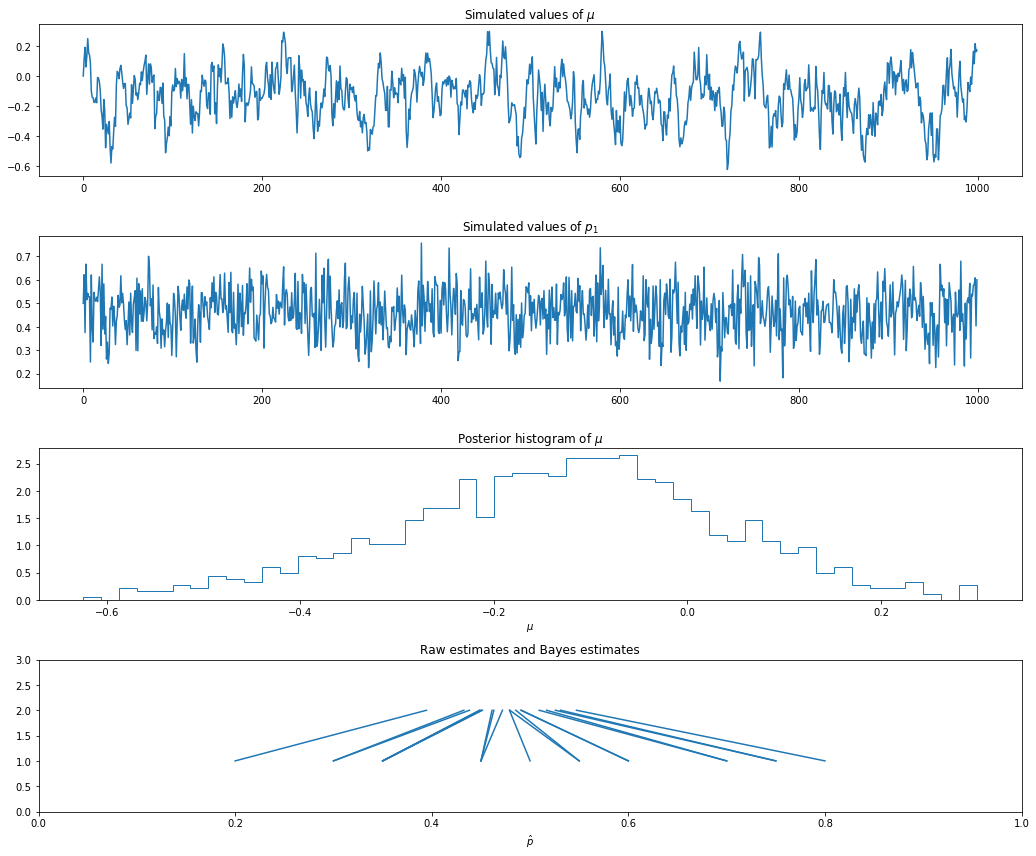

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14.5, 12))

nn = np.arange(0, N + 1)

ax = plt.subplot(4, 1, 1)
ax.plot(results['mu'])
ax.set_title('Simulated values of $\mu$')

ax = plt.subplot(4, 1, 2)
ax.plot(results['p'][:, 0])
ax.set_title('Simulated values of $p_1$')


raw_estimate = Y / 20
bayes_estimate = results['p'].mean(axis=0)

ax = plt.subplot(4, 1, 3)
ax.hist(results['mu'], density=True, histtype='step', bins=50)
ax.set_xlabel('$\mu$')
ax.set_title('Posterior histogram of $\mu$')

ax = plt.subplot(4, 1, 4)
for i in range(20):
    ax.plot([raw_estimate[i], bayes_estimate[i]], [1, 2], color='C0')
    
ax.set_ylim(0, 3)
ax.set_xlim(0, 1)
ax.set_xlabel('$\hat{p}$')
ax.set_title('Raw estimates and Bayes estimates')

plt.tight_layout()
plt.show()

After running the chain, we convert each $\psi_i$ back into $p_i = e^{\psi_i} / (1 + e^{\psi_i})$. Note that the Bayes estimates are "shrunk" together.  The parameter $\tau$ controls the amount of shrinkage.  We set $\tau = 1$ but, in practice, we should treat $\tau$ as another parameter and let the data determine how much shrinkage is needed.

So far we assumed that we know how to draw samples from the conditionals $f_{X | Y}(x | y)$ and $f_{Y | X}(y | x)$.  If we don't know how, we can still use Gibbs sampling algorithm by drawing each observation using a Metropolis-Hastings step.  Let $q$ be a proposal distribution for $x$ and let $\overline{q}$ be a proposal distribution for $y$.  When we do a Metropolis step for $X$ we treat $Y$ as fixed.  Similarly, when we do a Metropolis step for $Y$, we treat $X$ as fixed.  Here are the steps:

#### Metropolis with Gibbs

(1a)  Draw a proposal $Z \sim q(z | X_n)$.

(1b)  Evaluate

$$ r = \min \left\{ \frac{f(Z, Y_n)}{f(X_n, Y_n)} \frac{q(X_n | Z)}{q(Z | X_n)}, 1\right\} $$

(1c)  Set

$$ X_{n+1} = \begin{cases}
Z &\text{with probability } r \\
X_{n} &\text{with probability } 1 - r
\end{cases} $$

(2a)  Draw a proposal $Y \sim \overline{q}(z | Y_n)$.

(2b)  Evaluate

$$ \overline{r} = \min \left\{ \frac{f(X_{n+1}, Z)}{f(X_{n+1}, Y_n)} \frac{\overline{q}(Y_n | Z)}{\overline{q}(Z | Y_n)}, 1 \right\} $$

(2c)  Set

$$ Y_{n+1} = \begin{cases}
Z &\text{with probability } r \\
Y_n &\text{with probability } 1 - r
\end{cases}
$$

Again, this generalized to more than two dimensions.

### 25.7 Exercises

*Exercises taken from latest edition*

**Exercise 25.7.1**.  Let

$$ I = \int_1^2 \frac{e^{-x^2 / 2}}{\sqrt{2 \pi}} \; dx $$

**(a)** Estimate $I$ using the basic Monte Carlo method.  Use $N = 100,000$.  Also, find the estimated standard error.

**(b)** Find an (analytical) expression for the standard error of your estimate in (a).  Compare to the estimated standard error.

**(c)** Estimate $I$ using importance sampling.  Take $g$ to be $N(1.5, v^2)$ with $v = .1$, $v = 1$ and $v = 10$.  Compute the (true) standard errors in each case.  Also, plot a histogram of the values you are averaging to see if there are any extreme values.

**(d)** Find the optimal importance sampling function $g^*$.  What is the standard error using $g^*$?

**Solution**.

**(a)**  We have:

$$ I = \int_1^2 \phi(x) dx = \Phi(2) - \Phi(1) $$

where $\phi$ is the probability density function of $N(0, 1)$ and $\Phi$ is the cumulative density function.  The basic Monte Carlo method is to compute

$$ I = \frac{1}{N} \sum_{i=1}^N Y_i,
\quad Y_i = w(X_i) = I(1 \leq X_i \leq 2)
$$

where $X_i$ are drawn from $N(0, 1)$, and the estimated standard error is given by

$$ \hat{\text{se}} = \frac{s}{\sqrt{N}} 
\quad \text{where} \quad
s^2 = \frac{\sum_i (Y_i - \hat{I})^2}{N - 1}
$$

In [20]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm_notebook

np.random.seed(0)

N = 100000
true_value = norm.cdf(2) - norm.cdf(1)

def h(x):
    return np.where((1 < x) & (x < 2), 1, 0)

X = np.random.normal(loc=0.0, scale=1.0, size=N)
Y = h(X)

I_hat = np.empty(N)
se_hat = np.empty(N)
for n in tqdm_notebook(range(N)):
    I_hat[n] = Y[:n+1].mean()
    if n < 2:
        se_hat[n] = np.inf
    else:
        s2 = np.sum((Y[:n+1] - I_hat[n])**2) / n
        se_hat[n] = np.sqrt(s2 / (n + 1))
        
z = norm.ppf(0.975)

I_lower = I_hat - z * se_hat
I_upper = I_hat + z * se_hat

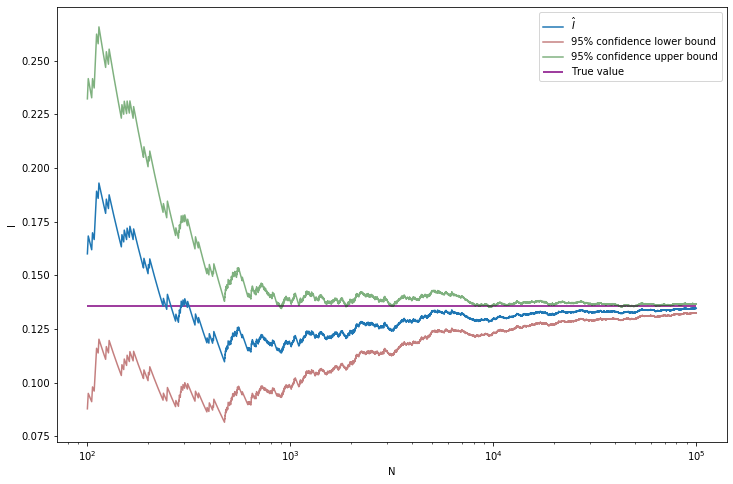

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

nn = np.arange(100, N + 1)

plt.figure(figsize=(12, 8))
plt.plot(nn, I_hat[nn - 1], label=r'$\hat{I}$')
plt.plot(nn, I_lower[nn - 1], label='95% confidence lower bound', color='darkred', alpha=0.5)
plt.plot(nn, I_upper[nn - 1], label='95% confidence upper bound', color='darkgreen', alpha=0.5)
plt.hlines(true_value, xmin=min(nn), xmax=max(nn), label='True value', color='purple')
plt.xlabel('N')
plt.ylabel('I')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

In [22]:
print('Estimated standard error: \t %.8f' % se_hat[-1])

Estimated standard error: 	 0.00107918


**(b)**  This is an unbiased estimator, with error $\epsilon_i = Y_i - I$ having expectation 0.  The variance of each error is $ \mathbb{V}[\epsilon_i] = \mathbb{V}[Y_i] = \mathbb{E}[Y_i^2] - \mathbb{E}[Y_i]^2$.  Buy by construction $\mathbb{E}[Y_i] = I = \Phi(2) - \Phi(1)$, and $Y_i = Y_i^2$, so $\mathbb{E}[Y_i^2] = \mathbb{E}[Y_i] = I$.  Then,

$$ \mathbb{V}[\epsilon_i] = \mathbb{V}[Y_i] = \mathbb{E}[Y_i^2] - \mathbb{E}[Y_i]^2 = I - I^2 $$

and so

$$ \mathbb{E}[\text{se}^2] = \mathbb{E}\left[\frac{s^2}{N}\right] = \frac{1}{N(N - 1)} \sum_i \mathbb{E}[\epsilon^2] = \frac{1}{N(N - 1)} \sum_i \mathbb{V}[\epsilon_i] = \frac{1}{N - 1} (I - I^2) $$

Let's compare the difference in the estimated standard error and this analytic estimate (square root of expectation of variance):

In [23]:
analytic_se = np.sqrt((true_value - true_value**2) / (N - 1))

print('Estimated standard error: \t\t %.8f' % se_hat[-1])
print('Analytic estimated standard error: \t %.8f' % analytic_se)
print('Difference between values: \t\t %.8f' % (analytic_se - se_hat[-1]))

Estimated standard error: 		 0.00107918
Analytic estimated standard error: 	 0.00108368
Difference between values: 		 0.00000450


**(c)** For importance sampling, we do

$$ \hat{I} = \frac{1}{N} \sum_i Y_i = \frac{1}{N} \sum_i \frac{h(X_i) f(X_i)}{g(X_i)} $$

where:

- $X$ is drawn from $N(0, 1)$
- $f = \phi$ is the density of the standard normal
- $h(x) = I(1 \leq x \leq 2)$
- $g$ is the density of $N(1.5, v^2)$, for $v = .1$, $v = 1$, $v = 10$.

In [24]:
import numpy as np
import numpy as np
from scipy.stats import norm
from tqdm import tqdm_notebook

np.random.seed(0)

B = 1000
N = 100000

true_value = 1 - norm.cdf(3)

def f_over_g(mu_g, sigma_g):
    def f(x):
        with np.errstate(over='ignore'):
            return np.exp(-(1/2) * (x**2 - ((x - mu_g) / sigma_g)**2))
    return f

I_bootstrap = {}
for v in [0.1, 1, 10]:    
    I_bootstrap[v] = np.empty(B)
    for b in tqdm_notebook(range(B)):
        XX = np.random.normal(loc=4.0, scale=1.0, size=N)
        YY = np.where((1 < XX) & (XX < 2), f_over_g(1.5, v)(XX), 0)
        I_bootstrap[v][b] = YY.mean()

In [25]:
for v in [0.1, 1, 10]:
    E_I = I_bootstrap[v].mean()
    print('Expected value of I | v = %.1f : \t %.5f' % (v, E_I))

Expected value of I | v = 0.1 : 	 56.89318
Expected value of I | v = 1.0 : 	 0.00568
Expected value of I | v = 10.0 : 	 0.00546


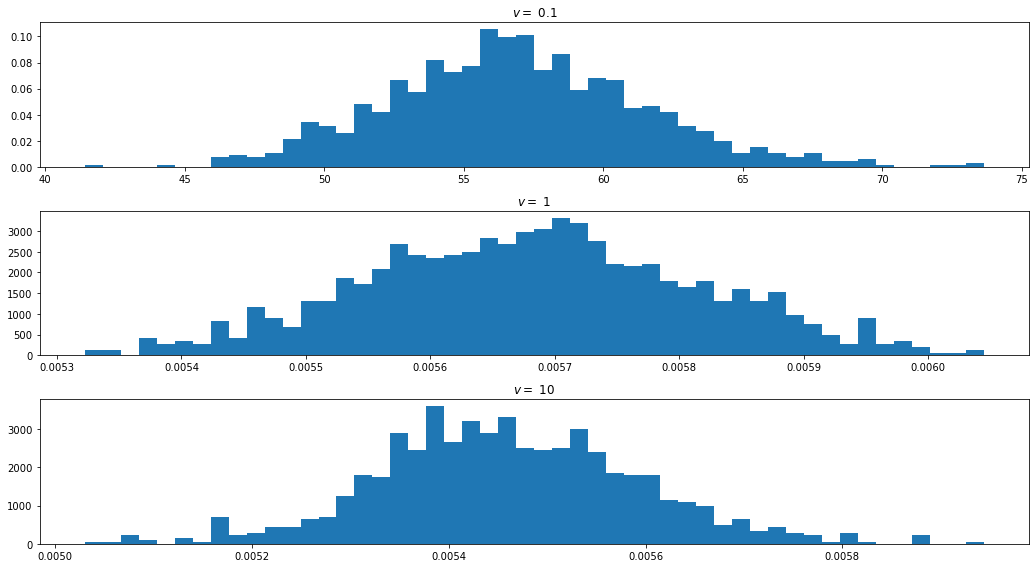

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14.5, 8))

for i, v in enumerate([0.1, 1, 10]):
    
    ax = plt.subplot(3, 1, i + 1)
    ax.hist(I_bootstrap[v], density=True, bins=50)
    ax.set_title('$v = $ ' + str(v))

plt.tight_layout()
plt.show()

There is obviously something unusual happening with $v = 0.1$ -- the estimated values are off by orders of magnitude compared to the other values.

The true variance of $w = f h / g$ is, in general,

$$
\begin{align}
\mathbb{V}_g[w] = \mathbb{E}_g[w^2] - (\mathbb{E}_g[w])^2 &= \int w^2(x) g(x) dx - \left( \int w(x) g(x) dx \right)^2 \\
&= \int \frac{h^2(x) f^2(x)}{g^2(x)} g(x) dx - \left( \int \frac{h(x) f(x)}{g(x)} g(x) dx \right)^2 \\
&= \int \frac{h^2(x) f^2(x)}{g^2(x)} g(x) dx - \left( \int h(x) f(x) dx \right)^2
\end{align}
$$

and, in this specific case, $h^2(x) = h(x) = I(1 \leq x \leq 2)$, and $I = \int h(x) f(x) dx = \Phi(2) - \Phi(1)$, so

$$
\begin{align}
\mathbb{V}_g[w] &= \int_1^2 \frac{f^2(x)}{g(x)} dx - I^2 \\
&= \int_1^2 \frac{\frac{1}{2 \pi} \exp \left\{-x^2 \right\}}{\frac{1}{\sigma_g \sqrt{2 \pi}} \exp \left\{-\frac{1}{2} \left(\frac{x - \mu_g}{\sigma_g}\right)^2 \right\} } dx - I^2 \\
&= \sigma_g \int_1^2 \frac{1}{\sqrt{2 \pi}} \exp \left\{ -x^2 +\frac{1}{2} \left(\frac{x - \mu_g}{\sigma_g}\right)^2 \right\} dx - I^2
\end{align}
$$

If $2 \sigma_g^2 - 1 > 0$, we can complete the square in the exponent to make it proportional to a Gaussian PDF.  Rewrite the exponent as

$$ 
\begin{align}
-x^2 +\frac{1}{2} \left(\frac{x - \mu_g}{\sigma_g}\right)^2 &= -\frac{1}{2} \left( 2x^2 -  \left(\frac{x - \mu_g}{\sigma_g}\right)^2 \right) \\
&= -\frac{1}{2} \frac{1}{\sigma_g^2} \left( 2 \sigma_g^2 x^2  - x^2 - 2 \mu_g x + \mu_g^2 \right) \\
&= -\frac{1}{2} \frac{1}{\sigma_g^2} \left( x^2 (2\sigma_g^2 - 1) - 2x \mu_g + \mu_g^2 \right) \\
&= -\frac{1}{2} \frac{2\sigma_g^2 - 1}{\sigma_g^2} \left( x^2 - 2x \frac{\mu_g}{2\sigma_g^2 - 1} + \frac{\mu_g^2}{2\sigma_g^2 - 1} \right) \\
&= -\frac{1}{2} \frac{2\sigma_g^2 - 1}{\sigma_g^2} \left( \left( x - \frac{\mu_g}{2\sigma_g^2 - 1} \right)^2  + \frac{\mu_g^2}{2\sigma_g^2 - 1}\left(1 - \frac{1}{2\sigma_g^2 - 1} \right) \right) \\
&= -\frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2 - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right)
\end{align}
$$

where 

$$ \mu_a = \frac{\mu_g}{2\sigma_g^2 - 1} 
\quad \text{and} \quad
\sigma_a = \frac{\sigma_g}{\sqrt{2 \sigma_g^2 - 1}} $$

Replacing above, we get

$$
\begin{align}
\mathbb{V}_g[w] &= \sigma_g \int_1^2 \frac{1}{\sqrt{2 \pi}} \exp \left\{ -x^2 +\frac{1}{2} \left(\frac{x - \mu_g}{\sigma_g}\right)^2 \right\} dx - I^2 \\
&= \sigma_g \int_1^2 \frac{1}{\sqrt{2 \pi}} \exp \left\{ -\frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2 \right\} \exp \left\{ - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right) \right\} dx - I^2 \\
&= \sigma_g \exp \left\{ - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right) \right\} \int_1^2 \frac{1}{\sqrt{2 \pi}} \exp \left\{ -\frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2 \right\} dx - I^2 \\
&= \sigma_g \exp \left\{ - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right) \right\} \int_{\frac{1 - \mu_a}{\sigma_a}}^{\frac{2 - \mu_a}{\sigma_a}} \frac{1}{\sqrt{2 \pi}} \exp \left\{ -\frac{1}{2} y^2 \right\} \frac{1}{\sigma_a} dy - I^2 \\
&= \frac{\sigma_g}{\sigma_a} \exp \left\{ - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right) \right\}  \left( \Phi\left(\frac{2 - \mu_a}{\sigma_a}\right) - \Phi\left(\frac{1 - \mu_a}{\sigma_a}\right) \right) - \left( \Phi(2) - \Phi(1) \right)^2
\end{align}
$$

For the case where $2 \sigma_g^2 - 1 < 0$, the coefficient of $x^2$ in the exponent of 

$$ \int \frac{1}{\sqrt{2 \pi}} \exp \left\{ -x^2 +\frac{1}{2} \left(\frac{x - \mu_g}{\sigma_g}\right)^2 \right\} dx $$

is positive, the indefinite integral does not diverge, and we can't express this as a Gaussian PDF.  Instead, we can express the definite integral as a function of the imaginary error function,

$$ \text{erfi}(z) = \frac{2}{\sqrt{\pi}} \int_0^z e^{t^2} dt $$

The exponent becomes:

$$ 
-x^2 +\frac{1}{2} \left(\frac{x - \mu_g}{\sigma_g}\right)^2 = \frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2 - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right)
$$

where

$$ \mu_a = \frac{\mu_g}{2\sigma_g^2 - 1} 
\quad \text{and} \quad
\sigma_a = \frac{\sigma_g}{\sqrt{1 - 2 \sigma_g^2}} $$

and we get:

$$
\begin{align}
\mathbb{V}_g[w] &= \sigma_g \int_1^2 \frac{1}{\sqrt{2 \pi}} \exp \left\{ -x^2 +\frac{1}{2} \left(\frac{x - \mu_g}{\sigma_g}\right)^2 \right\} dx - I^2 \\
&= \sigma_g \int_1^2 \frac{1}{\sqrt{2 \pi}} \exp \left\{ \frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2 \right\} \exp \left\{ - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right) \right\} dx - I^2 \\
&= \sigma_g \exp \left\{ - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right) \right\} \frac{1}{\sqrt{2 \pi}} \int_1^2 \exp \left\{ \frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2 \right\} dx - I^2 \\
&= \sigma_g \exp \left\{ - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right) \right\} \frac{1}{\sqrt{2 \pi}} \int_{\frac{1 - \mu_a}{\sigma_a}}^{\frac{2 - \mu_a}{\sigma_a}} \exp \left\{ \frac{1}{2} y^2 \right\} \frac{1}{\sigma_a} dy - I^2 \\
&= \sigma_g \exp \left\{ - \frac{1}{2} \frac{\mu_g^2}{\sigma_g^2} \left(1 - \frac{1}{2\sigma_g^2 - 1} \right) \right\} \sqrt{\frac{\pi}{2}} \sigma_a \left( \text{erfi}\left( \frac{\mu_a - 1}{\sqrt{2} \sigma_a} \right) - \text{erfi}\left( \frac{\mu_a - 2}{\sqrt{2} \sigma_a} \right) \right) - \left( \Phi(2) - \Phi(1) \right)^2
\end{align}
$$

Finally, when $\sigma_g = \sqrt{2}$, the $x^2$ term on the exponent cancels out, and we get:

$$
\begin{align}
-x^2 + \frac{1}{2} \left(\frac{x - \mu_g}{\sigma_g}\right)^2 &= -2 \mu_g x + \mu_g^2
\end{align}
$$

Replacing on the expression for the variance, we get:

$$
\begin{align}
\mathbb{V}_g[w] &= \sigma_g \int_1^2 \frac{1}{\sqrt{2 \pi}} \exp \left\{ -x^2 +\frac{1}{2} \left(\frac{x - \mu_g}{\sigma_g}\right)^2 \right\} dx - I^2 \\
&= \sigma_g \int_1^2 \frac{1}{\sqrt{2 \pi}} \exp \left\{ -2 \mu_g x + \mu_g^2 \right\} dx - I^2 \\
&= \frac{\sigma_g }{\sqrt{2 \pi} \mu_g} \left( \exp \left\{ (\mu_g (\mu_g - 3) \right\} \; \text{sinh} (\mu_g) \right) - \left( \Phi(2) - \Phi(1) \right)^2
\end{align}
$$

In [27]:
from scipy.stats import norm
from scipy.special import erfi

def compute_variance(mu_g, sigma_g):
    
    # Shift sigma_g slightly rather than coding special case on limit
    mu_a = mu_g / (2 * (sigma_g**2) - 1)
    sigma_a = sigma_g / np.sqrt(np.maximum(1e-120, np.abs(2 * (sigma_g**2) - 1)))
    
    return np.where(
        sigma_g > np.sqrt(1 / 2),
        sigma_g / sigma_a * \
            np.exp(-(1/2) * (mu_g**2) / (sigma_g**2) * (1 - 1/(2 * (sigma_g**2) - 1))) * \
            (norm.cdf((2 - mu_a) / sigma_a) - norm.cdf((1 - mu_a) / sigma_a)) \
            - (norm.cdf(2) - norm.cdf(1))**2,
        sigma_g * np.exp(-(1/2) * (mu_g**2) / (sigma_g**2) * (1 - 1/(2 * (sigma_g**2) - 1))) * \
            np.sqrt(np.pi / 2) * sigma_a * \
                (erfi((mu_a - 1) / (np.sqrt(2) * sigma_a)) - erfi((mu_a - 2) / (np.sqrt(2) * sigma_a)) ) \
            - (norm.cdf(2) - norm.cdf(1))**2   
    )
    
    return sigma_g / sigma_a * \
        np.exp(-(1/2) * (mu_g**2) / (sigma_g**2) * (1 - 1/(2 * (sigma_g**2) - 1))) * \
        (norm.cdf((2 - mu_a) / sigma_a) - norm.cdf((1 - mu_a) / sigma_a)) \
        - (norm.cdf(2) - norm.cdf(1))**2 

In [28]:
mu_g = 1.5
sigma_g = np.logspace(-1, 1)
standard_error = np.sqrt(compute_variance(mu_g, sigma_g))

In [29]:
for v in [0.1, 1.0, 10]:
    se = np.log10(np.sqrt(compute_variance(1.5, v)))
    print('Log10 of standard error of I | v = %.1f:   %.5f' % (v, se))

Log10 of standard error of I | v = 0.1:   81.50661
Log10 of standard error of I | v = 1.0:   -0.21918
Log10 of standard error of I | v = 10.0:   0.01540


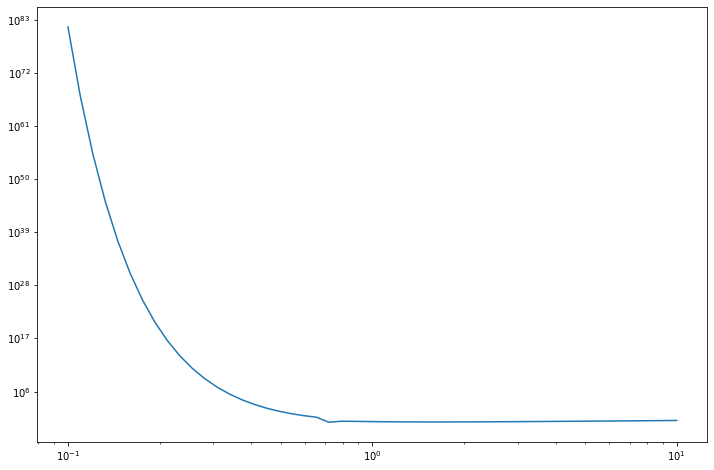

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.plot(sigma_g, standard_error)
plt.yscale('log')
plt.xscale('log')
plt.show()

The variance (and the standard error) blows up as $v = \sigma_g$ becomes smaller, as we are integrating a diverging term (positive coefficient for $x^2$ on an exponential). 

The minimum true variance in this class of functions $g \sim N(1.5, \sigma_g^2)$ occurs on the edge case where $\sigma_g = 1 / \sqrt{2}$.

**(d)**   From theorem 25.5, the choice of $g$ that minimizes the variance is

$$ g^*(x) = \frac{|h(x)| f(x) }{\int | h(s) | f(s)  ds} $$

Since $h(x) = I(1 < x < 2)$, $f(x) = \phi(x)$, and the integral is $I = \int_1^2 f(s) ds = \Phi(2) - \Phi(1)$, we can write

$$ g^*(x) = \begin{cases}
\frac{\phi(x)}{\Phi(2) - \Phi(1)} &\text{if } 1 \leq x \leq 2 \\
0 &\text{otherwise }
\end{cases}
$$

The minimum variance is 

$$ \int_1^2 \frac{f^2(x)}{g^*(x)} dx - I^2 = \int_1^2 \frac{\phi^2(x)}{\frac{\phi(x)}{I}} dx - I^2 = I \left( \int_1^2 \phi(x) dx \right) - I^2 = I \cdot I - I^2 = 0 $$

**Exercise 25.7.2**.  Here is a way to use importance sampling to estimate a marginal density.  Let $f_{X, Y}(x, y)$ be a bivariate density and let $(X_1, Y_1), \dots, (X_N, Y_N) \sim f_{X, Y}$.

**(a)**  Let $w(x)$ be an arbitrary probability density function.  Let

$$ \hat{f}_X(x) = \frac{1}{N} \sum_{i=1}^N \frac{f_{X, Y}(x, Y_i)  w(X_i)}{f_{X, Y}(X_i, Y_i)} $$

Show that, for each $x$,

$$ \hat{f}_X(x) \xrightarrow{\text{P}} f_X(x) $$

Find an expression for the variance of this estimator.

**(b)** Let $Y \sim N(0, 1)$ and $X | Y = y \sim N(y, 1 + y^2)$.  Use the method in (a) to estimate $f_X(x)$.

**Solution**.

**(a)**

The key idea for importance sampling is to change the probability measure based on which an expectation is calculated.  We say that the expectation of a random variable $X$ under a probability density function $f$ is $\mathbb{E}_f[X]$ when

$$ \mathbb{E}_f[X] = \int x f(x) dx$$

If we pick any new random variable $L \geq 0$ with $\mathbb{E}_{\mathbb{P}}[L] = 1$ and almost everywhere $L(\omega) \neq 0$, we can use it to define a new probability density function $g$ such that

$$ \mathbb{E}_g\left[\frac{X}{L}\right] = \mathbb{E}_f[X] $$

by defining a new density function $g$ such that

$$ g\left(s\right) = \mathbb{P}\left[\frac{X}{L} = s\right] = \int \int_{\frac{a}{b} = s} f_X(a) f_L(b) \; da\; db $$

which leads to

$$ \mathbb{E}_g\left[\frac{X}{L}\right] = \int \frac{x}{\ell} g\left(\frac{x}{\ell}\right) d \left( \frac{x}{\ell} \right) = \int x f(x) \left( \int \frac{1}{\ell} f_L(\ell) d\ell \right) dx  = \int x f(x) dx  = \mathbb{E}_f[X]$$

Then, if we want to estimate, for some function $h$, $\mathbb{E}_f[h(X)] = \int h(x) f(x) dx$, we can pick another arbitrary distribution $g$ for $Z = h(X) / L$, sample $Z_i \sim g$, and use the estimator

$$ \hat{\mathbb{E}}_g\left[\frac{h(X)}{L}\right] = \frac{1}{N} \sum_{i=1}^N \frac{h(Z_i) f(Z_i)}{g(Z_i)} $$

as it converges to $\mathbb{E}_g\left[h(X) / L\right]$ by the law of large numbers, and this expectation is the same as $\mathbb{E}_f[h(X)]$ by construction.

Now, consider the bivariate distribution $Z = (X, Y) \sim f_{X, Y}$, let $g = f_{X, Y}$, and for some constant $x_0$ define

$$ h(x, y) = \frac{f_{X, Y}(x_0, y) w(x) }{ f_{X, Y}(x, y) } $$

The expected value of $h(X, Y)$ is:

$$
\begin{align}
\mathbb{E}[h(X, Y)] &= \int \int h(x, y) f_{X, Y}(x, y) \; dx dy \\
&= \int \int \frac{f_{X, Y}(x_0, y) w(x)}{f_{X, Y}(x, y)} f_{X, Y}(x, y) \; dx dy \\
&= \int \int f_{X, Y}(x_0, y) w(x) \; dx dy \\
&= \int \left(\int f_{X, Y}(x_0, y) \; dy \right) w(x) \; dx \\
&= \int f_X(x_0) w(x) \; dx \\
&= f_X(x_0) \left( \int w(x) \; dx \right) \\
&= f_X(x_0)
\end{align}
$$

since $w$ is a PDF and integrates to 1.  But, by construction, we have

$$ 
\frac{h(X_i, Y_i) f(X_i, Y_i)}{g(X_i, Y_i)}
=
\frac{f(x_0, Y_i) w(X_i)}{f(X_i, Y_i)}
$$

and so the estimator

$$ \hat{f}_X(x_0) \equiv \frac{1}{N} \sum_{i=1}^N \frac{f_{X, Y}(x_0, Y_i)  w(X_i)}{f_{X, Y}(X_i, Y_i)} $$

converges to $\mathbb{E}_f[h(X, Y)] = f_X(x_0)$, which is our result.

The variance of the estimator (which is unbiased) is

$$
\begin{align}
\mathbb{E}_g\left[ \left(\frac{h(X, Y) f_{X, Y}(X, Y)}{g(X, Y)} \right)^2 \right]
&= \int \int \left( \frac{h(x, y) f_{X, Y}(x, y)}{g(x, y)} \right)^2 g(x, y) \; dx dy \\
&= \int \int \frac{h^2(x, y) f_{X, Y}^2(x, y)}{g(x, y)} \; dx dy
\end{align}
$$

and, replacing our choices for $h$ and $g$,

$$
\begin{align}
\mathbb{E}_g\left[ \left(\frac{h(X, Y) f_{X, Y}(X, Y)}{g(X, Y)} \right)^2 \right]
&= \int \int h^2(x, y) f_{X, Y}(x, y) \; dx dy \\
&= \int \int \frac{f_{X, Y}^2(x_0, y) w^2(x) }{ f_{X, Y}^2(x, y) } f_{X, Y}(x, y) \; dx dy \\
&= \int f_{X, Y}^2(x_0, y) \left( \int \left(\frac{w(x)}{f_{X, Y}(x, y)}\right)^2 f_{X, Y}(x, y) \; dx \right) \; dy \\
&= \int f_{X, Y}^2(x_0, y) \mathbb{E}_X\left[ \left(\frac{w(x)}{f_{X, Y}(x, y)}\right)^2 \right] dy \\
&= \int \mathbb{E}_X\left[ f_{X, Y}(x_0, y) \left(\frac{w(x)}{f_{X, Y}(x, y)}\right)^2 \right] f_{X, Y}(x_0, y) \; dy \\
&= \mathbb{E} \left[  f_{X, Y}(x_0, Y) \left(\frac{w(X)}{f_{X, Y}(X, Y)}\right)^2 \right]
\end{align}
$$

**(b)**  The formula for the joint distribution PDF is

$$ 
\begin{align}
f_{X, Y}(x, y) &= f_Y(y) f_{X | Y}(x | y) \\
&= \left( \frac{1}{\sqrt{2 \pi}} \exp \left\{ -\frac{1}{2} y^2 \right\} \right)
\left( \frac{1}{\sqrt{1 + y^2} \sqrt{2 \pi}} \exp \left\{ -\frac{1}{2} \left( \frac{x - y}{\sqrt{1 + y^2}} \right)^2\right\} \right) \\
&= \frac{1}{(2 \pi) \sqrt{1 + y^2}} \exp \left\{ -\frac{1}{2} \left( y^2 + \frac{(x - y)^2}{1 + y^2} \right) \right\}
\end{align}
$$

Let's pick $w$ as a t-distribution with $v = 5$.

In [31]:
import numpy as np
from scipy.stats import norm, t

np.random.seed(0)

def f(x, y):
    return 1 / (2 * np.pi * np.sqrt(1 + y**2)) * np.exp(-(1/2) * (y**2 + ((x - y)**2/(1 + y**2))))

def w(x):
    return t.pdf(x, df=5)

def importance_sampling(x0, N, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    Y = norm.rvs(size=N)
    X = norm.rvs(loc=Y, scale=np.sqrt(1 + Y**2), size=N)
    
    return np.array([np.mean(f(xx, Y) * w(X) / f(X, Y)) for xx in x0])

In [32]:
x0 = np.arange(-10, 10, step=0.05)
estimated_f = importance_sampling(x0, N=100000, seed=0)

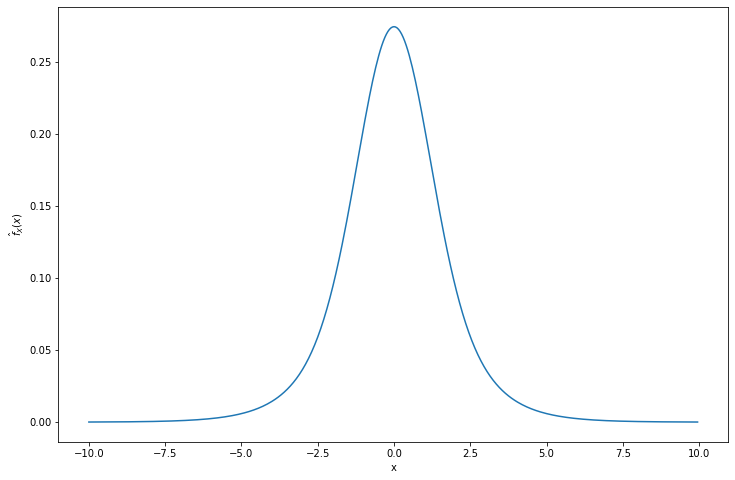

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.plot(x0, estimated_f)
plt.xlabel('x')
plt.ylabel('$\hat{f}_X(x)$')
plt.show()

**Exercise 25.7.3**.  Here is a method called **accept-reject sampling** for drawing observations from a distribution.

**(a)**  Suppose that $f$ is some probability density function.  Let $g$ be any other density and suppose that $f(x) \leq M g(x)$ for all $x$, where $M$ is a known constant.  Consider the following algorithm:

- Step 1:  Draw $X \sim g$ and $U \sim \text{Uniform}(0, 1)$.
- Step 2:  If $U \leq f(X) / (M g(X))$ set $Y = X$, otherwise go back to step 1.  (Keep repeating until you finally get an observation).

Show that the distribution of $Y$ is $f$.

**(b)** Let $f$ be a standard normal density and let $g(x) = 1 / (1 + x^2)$ be the Cauchy density.  Apply the method in (a) to draw 1,000 observations from the normal distribution.  Draw a histogram of the sample to verify that the sample appears to be normal.

**Solution**.

**(a)** The probability of accepting $Y = y$ is:

$$ \mathbb{P}\left(X = y, U \leq \frac{f(X)}{(M g(X))} \right) = g(y) \frac{f(y)}{M g(y)} = M f(y) $$

so the probability of the algorithm drawing $Y = y$ eventually is $h(y) \propto M f(y)$, and so $Y \sim f$.

**(b)**

The CDF of the Cauchy distribution is $G(x) = \frac{1}{\pi} \text{arctan}\left( x \right) + \frac{1}{2}$, so its inverse distribution is $G^{-1}(y) = \text{tan} \left( \pi \left( y - \frac{1}{2} \right) \right)$.

In [34]:
import numpy as np
from scipy.stats import norm

def accept_reject(N, M=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    def f(x):
        return norm.pdf(x)

    def g(x):
        return 1 / (1 + x**2)
    
    def G_inv(q):
        return np.tan(np.pi * (q - (1/2)))
        
    def draw_results(batch_size): 
        U = np.random.uniform(low=0, high=1, size=batch_size)
        Q = np.random.uniform(low=0, high=1, size=batch_size)
        X = G_inv(Q)

        return X[U <= f(X) / (M * g(X))]
    
    X = np.empty(N)
    cursor = 0
    while (cursor < N):
        XX = draw_results(N)
        nn = len(XX)
        X[cursor: min(cursor + nn, N)] = XX[:min(nn, N - cursor)]
        cursor += nn
    
    return X

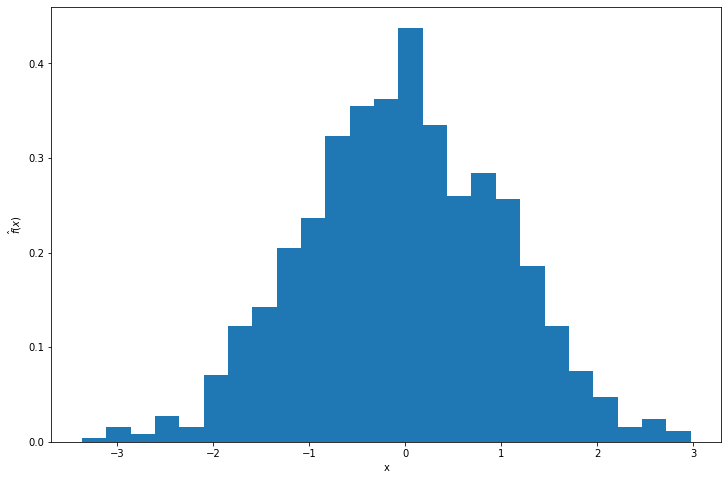

In [35]:
Y = accept_reject(N = 1000, M = 1, seed=0)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.hist(Y, bins=25, density=True)
plt.xlabel('x')
plt.ylabel(r'$\hat{f}(x)$')
plt.show()

**Exercise 25.7.4**.  A random variable $Z$ has an **inverse Gaussian distribution** if it has density

$$ f(z) \propto z^{-3/2}  \exp \left\{ -\theta_1 z - \frac{\theta_2}{z} + 2 \sqrt{\theta_1 \theta_2}  + \log \left( \sqrt{2 \theta_2} \right) \right\}, \quad z > 0$$ 

where $\theta_1 > 0$ and $\theta_2 > 0$ are parameters.  It can be shown that

$$ 
\mathbb{E}[Z] = \sqrt{\frac{\theta_2}{\theta_1}} 
\quad \text{and} \quad
\mathbb{E}\left[ \frac{1}{Z} \right] = \sqrt{\frac{\theta_1}{\theta_2}} + \frac{1}{2 \theta_2}
$$

**(a)** Let $\theta_1 = 1.5$ and $\theta_2 = 2$.  Draw a sample of size 1,000 using the independence-Metropolis-Hastings method.  Use a Gamma distribution as the proposal density.  To assess the accuracy, compare the mean of $Z$ and $1 / Z$ from the sample to the theoretical means.  Try different Gamma distributions to see if you can get an accurate sample.

**(b)** Draw a sample of size 1,000 using the random-walk-Metropolis-Hastings method.  Sinze $z > 0$ we cannot just use a normal density.  One strategy is this.  Let $W = \log Z$.  Find the density of $W$.  Use the random-walk-Metropolis-Hastings method to get a sample $W_1, \dots, W_N$ and let $Z_i = e^{W_i}$.  Assess the accuracy of the simulation as in part (a).

**Solution**.

**(a)**.  The Independence-Metropolis-Hastings method is:

Choose $X_0$ arbitrarily.  Suppose we have generated $X_0, X_1, \dots, X_i$.  To generate $X_{i+1}$ do:

1. Generate a **proposal** or **candidate** value $Y \sim g$.
2. Evaluate $r \equiv r(X_i, Y)$ where

$$ r(x, y) = \min \left\{ 1, \frac{f(y)}{f(x)} \frac{g(x)}{g(y)} \right\} $$

3. Set

$$
X_{i+1} = \begin{cases}
Y   &\text{with probability } r \\
X_i &\text{with probability } 1 - r 
\end{cases}
$$

We will use a Gamma distribution for $g$; it has probability density function

$$ g_a(x) = \frac{x^{a - 1} e^{-x}}{\Gamma(a)} $$

for some parameter $a > 0$.

In [36]:
import numpy as np
from scipy.stats import gamma

def independence_metropolis_hastings(N, theta1, theta2, gamma_a, seed=None):
    if seed is not None:
        np.random.seed(seed)
            
    def f(z):
        return (z**(-3/2)) * np.exp(-theta1 * z - theta2 / z + 2 * np.sqrt(theta1 * theta2) + np.log(np.sqrt(2 * theta2)))
        
    def g(x):
        return gamma.pdf(x=x, a=gamma_a)
    
    U = np.random.uniform(low=0, high=1, size=N)
    X = np.empty(N+1)
    X[0] = 1
    Y = gamma.rvs(a=gamma_a, size=N+1)
    
    for i in range(1, N+1):
        r = min(1, (f(Y[i - 1]) * g(X[i - 1])) / (f(X[i - 1]) * g(Y[i - 1])))
        X[i] = Y[i - 1] if U[i - 1] < r else X[i - 1]
        
    return X[1:]

In [37]:
from tqdm import tqdm_notebook

gamma_as = np.logspace(-1, 1, num=200)

EZs = np.empty(len(gamma_as))
E_invZs = np.empty(len(gamma_as))

N = 1000
theta1, theta2 = 1.5, 2
for i, gamma_a in tqdm_notebook([(i, gamma_a) for i, gamma_a in enumerate(gamma_as)]):
    Z = independence_metropolis_hastings(N=N, theta1=theta1, theta2=theta2, gamma_a=gamma_a, seed=0)
    EZs[i] = Z.mean()
    E_invZs[i] = (1 / Z).mean()

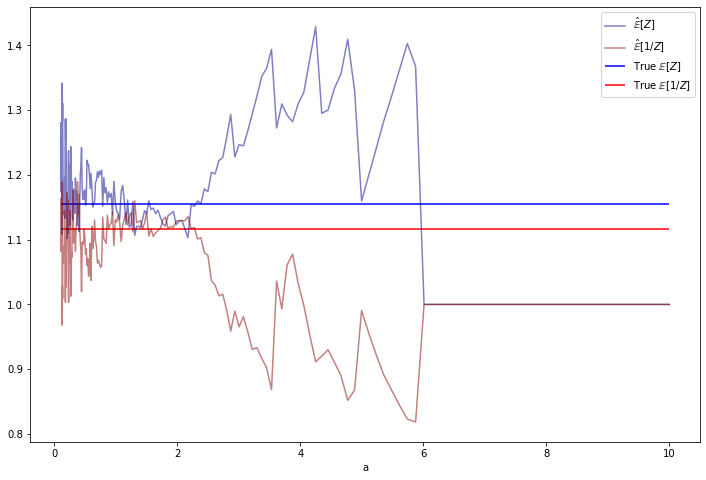

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

theta1, theta2 = 1.5, 2
true_EZ = np.sqrt(theta2 / theta1)
true_E_invZ = np.sqrt(theta1 / theta2) + 1/(2 * theta2)

plt.figure(figsize=(12, 8))
plt.plot(gamma_as, EZs, label=r'$\hat{\mathbb{E}}[Z]$', color='darkblue', alpha=0.5)
plt.plot(gamma_as, E_invZs, label=r'$\hat{\mathbb{E}}[1 / Z]$', color='darkred', alpha=0.5)
plt.xlabel('a')

plt.hlines(true_EZ, xmin=min(gamma_as), xmax=max(gamma_as), label=r'True $\mathbb{E}[Z]$', color='blue')
plt.hlines(true_E_invZ, xmin=min(gamma_as), xmax=max(gamma_as), label=r'True $\mathbb{E}[1 / Z]$', color='red')
plt.legend(loc='upper right')
plt.show()

In [39]:
# Selected hyperparameter by minimizing sum of square errors

error_EZ = EZs - true_EZ
error_E_InvZ = E_invZs - true_E_invZ

MSE = error_EZ**2 + error_E_InvZ**2
selected_gamma_a = gamma_as[np.argmin(MSE)]

Z = independence_metropolis_hastings(N=100*N, theta1=theta1, theta2=theta2, gamma_a=selected_gamma_a, seed=0)

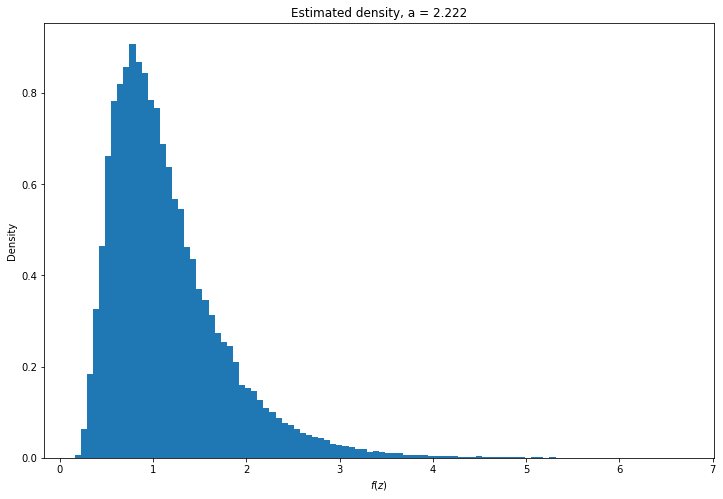

In [40]:
plt.figure(figsize=(12, 8))
plt.hist(Z, density=True, bins=100)
plt.xlabel('$f(z)$')
plt.ylabel('Density')
plt.title('Estimated density, a = %.3f' % selected_gamma_a)
plt.show()

**(b)**  The random-walk-Hastings-Metropolis method is:

Choose $X_0$ arbitrarily.  Suppose we have generated $X_0, X_1, \dots, X_i$.  To generate $X_{i+1}$ do:

1. Generate a **proposal** or **candidate** value $Y \sim q(y | X_i) = g(y - X_i)$.
2. Evaluate $r \equiv r(X_i, Y)$ where

$$ r(x, y) = \min \left\{ \frac{f(y)}{f(x)} \frac{q(x | y)}{q(y | x)}, 1 \right\} = \min \left\{ \frac{f(y)}{f(x)}, 1 \right\} $$

3. Set

$$
X_{i+1} = \begin{cases}
Y   &\text{with probability } r \\
X_i &\text{with probability } 1 - r 
\end{cases}
$$

We will do the transformation $W = \log Z$. The cumulative distribution function of $W$ is:

$$ F_{W}(w) = \mathbb{P}\left( W \leq w \right) = \mathbb{P}\left( Z \leq e^{w} \right) = F_Z(e^{w}) $$

and so, derivating on $w$, the probability density function is:

$$ f_W(w) = \frac{d}{dw} F_{W}(w) = \frac{d}{dw} F_Z(e^{w}) = \frac{d F_Z(e^{w})}{d e^{w}} \frac{d e^{w}}{ dw } = e^{w} f_Z(e^w) $$

and so

$$ f_W(w) \propto \exp \left\{ -\frac{w}{2}
-\theta_1 e^{w} - \theta_2 e^{-w} \right\} $$

We then translate back the generated values, $Z_i = e^{W_i}$  We will also use a Log-Gamma distribution for $g$ instead of a Gamma distribution.  The Log-Gamma distribution has probability density function:

$$ g_c(x) = \frac{\exp \{ cx - \exp \{ x \} \}}{\Gamma(c)} $$

for some parameter $c > 0$.

In [41]:
from scipy.stats import loggamma

def random_walk_hastings_metropolis(N, theta1, theta2, loggamma_c, seed=None):
    if seed is not None:
        np.random.seed(seed=seed)
        
    def f_w(w):
        return np.exp(-w/2 - theta1 * np.exp(w) - theta2 * np.exp(-w))
        
    def g(x):
        return loggamma.pdf(x=x, c=loggamma_c)
    
    U = np.random.uniform(low=0, high=1, size=N)
    X = np.empty(N+1)
    X[0] = 0
    
    for i in range(1, N+1):
        Y = loggamma.rvs(c=loggamma_c, loc=X[i - 1])
        r = min(1, f_w(Y) / f_w(X[i - 1]))
        X[i] = Y if U[i - 1] < r else X[i - 1]
        
    return np.exp(X[1:])

In [42]:
from tqdm import tqdm_notebook

loggamma_cs = np.logspace(-1, 1, num=100)

EZs = np.empty(len(loggamma_cs))
E_invZs = np.empty(len(loggamma_cs))

N = 1000
theta1, theta2 = 1.5, 2
for i, loggamma_c in tqdm_notebook([(i, loggamma_c) for i, loggamma_c in enumerate(loggamma_cs)]):
    Z = random_walk_hastings_metropolis(N=N, theta1=theta1, theta2=theta2, loggamma_c=loggamma_c, seed=0)
    EZs[i] = Z.mean()
    E_invZs[i] = (1 / Z).mean()

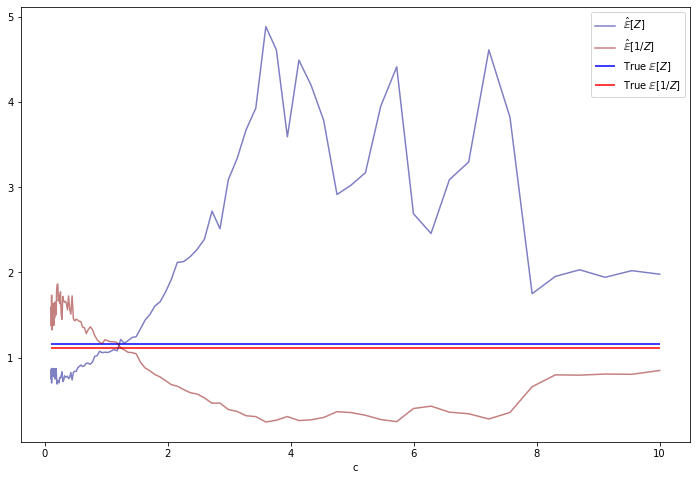

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

theta1, theta2 = 1.5, 2
true_EZ = np.sqrt(theta2 / theta1)
true_E_invZ = np.sqrt(theta1 / theta2) + 1/(2 * theta2)

plt.figure(figsize=(12, 8))
plt.plot(loggamma_cs, EZs, label=r'$\hat{\mathbb{E}}[Z]$', color='darkblue', alpha=0.5)
plt.plot(loggamma_cs, E_invZs, label=r'$\hat{\mathbb{E}}[1 / Z]$', color='darkred', alpha=0.5)
plt.xlabel('c')

plt.hlines(true_EZ, xmin=min(loggamma_cs), xmax=max(loggamma_cs), label=r'True $\mathbb{E}[Z]$', color='blue')
plt.hlines(true_E_invZ, xmin=min(loggamma_cs), xmax=max(loggamma_cs), label=r'True $\mathbb{E}[1 / Z]$', color='red')
plt.legend(loc='upper right')
plt.show()

In [44]:
# Selected hyperparameter by minimizing sum of square errors

error_EZ = EZs - true_EZ
error_E_InvZ = E_invZs - true_E_invZ

MSE = error_EZ**2 + error_E_InvZ**2
selected_loggamma_c = loggamma_cs[np.argmin(MSE)]

Z = random_walk_hastings_metropolis(N=100*N, theta1=theta1, theta2=theta2, loggamma_c=selected_loggamma_c, seed=0)

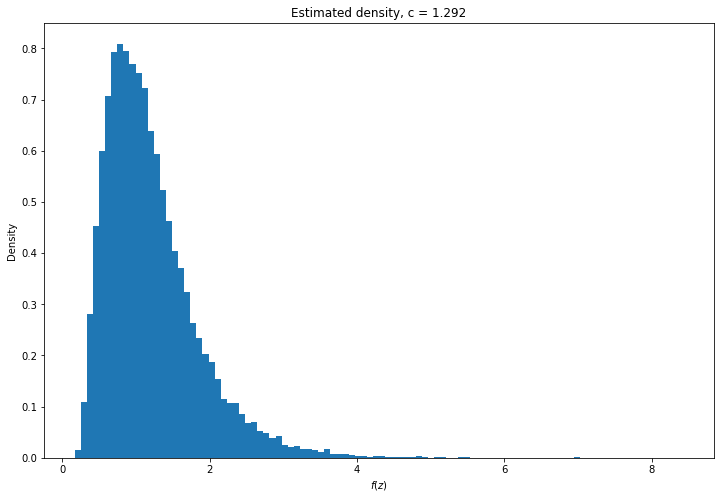

In [45]:
plt.figure(figsize=(12, 8))
plt.hist(Z, density=True, bins=100)
plt.xlabel('$f(z)$')
plt.ylabel('Density')
plt.title('Estimated density, c = %.3f' % selected_loggamma_c)
plt.show()

**Exercise 25.7.5**.  Get the heart disease data from the book website.  Consider a Bayesian analysis of the logistic regression model

$$ \mathbb{P}(Y = 1 | X = x) = \frac{e^{ \beta_0 + \sum_{j=1}^k \beta_j x_j } }{1 + e^{ \beta_0 + \sum_{j=1}^k \beta_j x_j }} $$

**(a)**  Use the flat prior $f(\beta_0, \dots, \beta_k) \propto 1$.  Use the Gibbs-Metropolis algorithm to draw a sample of size 10,000 from the posterior $f(\beta_0, \dots, \beta_k)$.  Plot histograms of the posteriors for the  $\beta_j$'s.  Get the posterior mean and a 95% posterior interval for each $\beta_j$.

**(b)** Compare your analysis to a frequentist approach using maximum likelihood.

**Solution**.

In [46]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/coris.csv')
del data['row.names']

X, Y = data[data.columns[data.columns != 'chd']], data['chd']

**(a)**  Given parameters $\beta = (\beta_0, \dots, \beta_k)$, and assuming a flat prior $f(\beta) \propto 1$, the posterior is

$$ f(\beta | \text{data}) = \frac{\mathcal{L}(\beta) f(\beta)}{\int \mathcal{L}(u) f(u) du} = \frac{\mathcal{L}(\beta)}{\int \mathcal{L}(u) du} \propto \mathcal{L}(\beta) $$

The likelihood is

$$ 
\begin{align}
\mathcal{L}(\beta) &= \prod_i \mathbb{P}(Y = Y_i | X = X_i)  \\
&= \prod_{i: Y_i = 1} \frac{e^{ \beta X_i } }{1 + e^{ \beta X_i }} \prod_{i: Y_i = 0} \frac{1}{1 + e^{ \beta X_i }} \\
&= \prod_i \frac{e^{ \beta X_i Y_i } }{1 + e^{ \beta X_i }}
\end{align}
$$

The Gibbs-Metropolis algorithm is:

- Start with an arbitrary variable $B^{(0)} = (B^{(0)}_0, B^{(0)}_1, \dots, B^{(0)}_k)$.
- For each step $i = 1, 2, \dots, N$, build $B^{(i)}$ as follows:
   - For each variable $\beta_j$, $j = 0, 1, \dots, k$, set $B_j^{(i)}$ as follows:

     -  Draw a proposal $Z$ for $B_j^{(i)}$ from a proposal distribution $q_{j}$
     -  Evaluate
      $$ r = \min \left\{ \frac{f\left(B_\text{proposal}\right)}{f\left(B_\text{current}\right)} \frac{q_{j}(Z | B_\text{current})}{q_{j}(B_\text{current} | Z)}, 1\right\} $$
      where 
      
      $$
      \begin{align}
      B_\text{proposal} &= \left(B_0^{(i)}, \dots, B_{j-1}^{(i)}, Z, B_{j + 1}^{(i - 1)} \dots, B_k^{(i - 1)}\right) \\
      B_\text{current} &= \left(B_0^{(i)}, \dots, B_{j-1}^{(i)}, B_{j}^{(i - 1)}, B_{j + 1}^{(i - 1)} \dots, B_k^{(i - 1)}\right)
      \end{align}
      $$
      
     -  Set
   
      $$ 
      B_j^{(i)} = \begin{cases}
      Z &\text{with probability } r \\
      B_j^{(i - 1)} &\text{with probability } 1 - r
      \end{cases}
      $$
      
The distribution of the $B^{(i)}$ should converge to the distribution of $\beta$.

We can pick symmetric proposal distributions $q_{j}$ to cancel out the conditional probabilities, and make the accept probability simply

$$ r = \min \left\{ \frac{f\left(B_\text{proposal}\right)}{f\left(B_\text{current}\right)}, 1\right\} $$

For example, let's make the proposals for $\beta_j$ be $Z \sim N(0, \sigma_j^2)$, with $\sigma_j$ to be selected based on the data.

In [47]:
from scipy.stats import norm
from scipy.special import expit
from tqdm import tqdm_notebook

Xp = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

def likelihood(beta):
    bx = beta @ Xp.T
    return (1 - expit(-np.sum(np.where(Y, bx, 0)))) * expit(-np.sum(np.where(1 - Y, bx, 0)))

def gibbs_metropolis(start, proposer, f, N, seed=None, show_progress=True):
    if seed is not None:
        np.random.seed(seed=seed)
    
    k = len(start)
    X = np.empty((N + 1, k))
    X[0] = start
    U = np.random.uniform(size=(N, k))
    
    iterator = tqdm_notebook(range(N)) if show_progress else range(N)
    
    for i in iterator:
        B_current = X[i].copy()
        for j in range(k):
            Z = proposer(j)
            B_proposal = B_current.copy()
            B_proposal[j] = Z
            
            r = min(f(B_proposal) / f(B_current), 1)
            if U[i, j] < r:
                B_current[j] = Z
                
        X[i + 1] = B_current
    
    return X[1:]

In [48]:
# Select a sigma_j based on max likelihood

sigma_js = np.logspace(-2, 0, num=20)
B_likelihoods = np.empty(len(sigma_js))

for i, sigma_j in tqdm_notebook([(i, sigma_j) for i, sigma_j in enumerate(sigma_js)]):
    B = gibbs_metropolis(np.zeros(10), lambda j : norm.rvs(scale=sigma_j), likelihood, N=1000, seed=0, show_progress=False)
    B_likelihoods[i] = likelihood(B.mean(axis = 0))

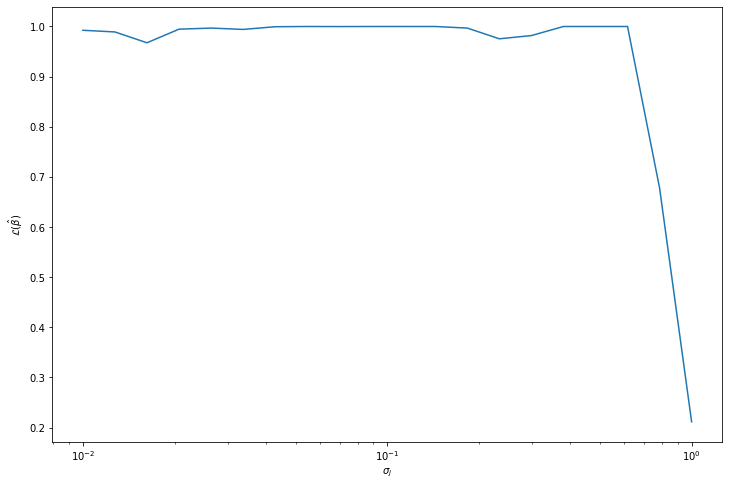

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.plot(sigma_js, B_likelihoods)
plt.xscale('log')
plt.xlabel(r'$\sigma_j$')
plt.ylabel(r'$\mathcal{L}(\hat{\beta})$')
plt.show()

In [50]:
selected_sigma_j = sigma_js[np.argmax(B_likelihoods)]

B = gibbs_metropolis(np.zeros(10), lambda j : norm.rvs(scale=selected_sigma_j), likelihood, N=100000, seed=0, 
                     show_progress=True)

In [51]:
posterior_mean = B.mean(axis = 0)
posterior_confidence_bounds = np.quantile(B, [0.025, 0.975], axis=0)

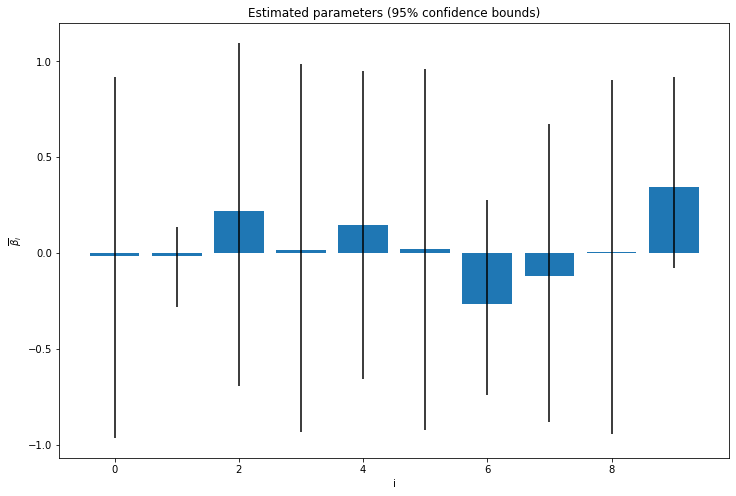

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.bar(np.arange(10), posterior_mean, yerr=np.abs(posterior_confidence_bounds - posterior_mean))
plt.xlabel('i')
plt.ylabel(r'$\overline{\beta}_i$')
plt.title('Estimated parameters (95% confidence bounds)')
plt.show()

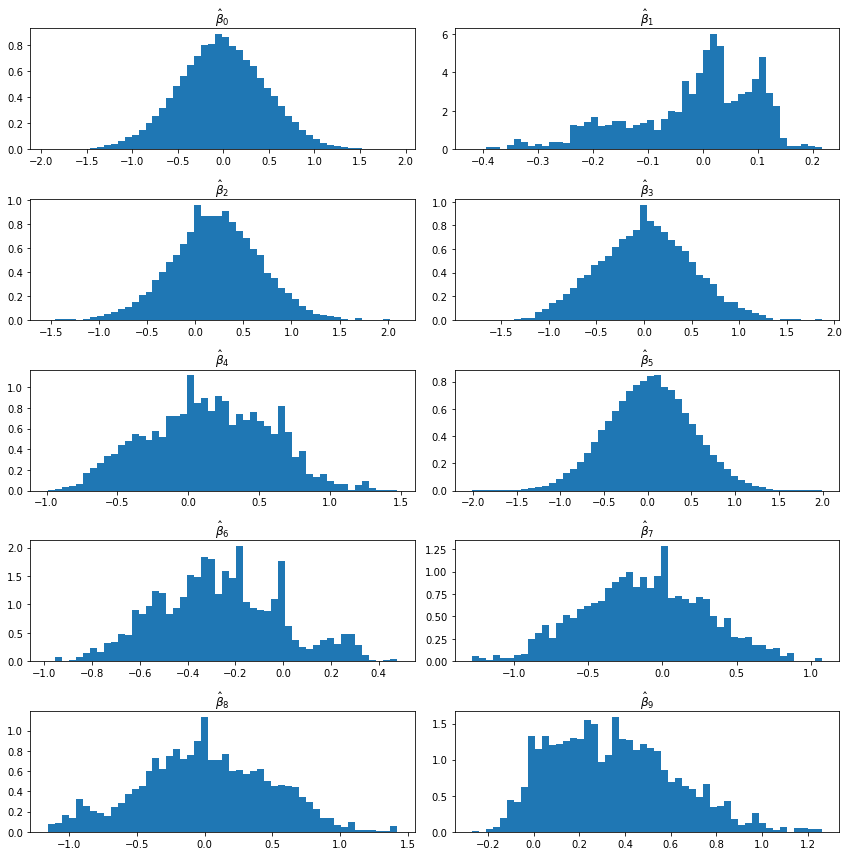

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
for i in range(0, 10):
    
    # Set up the plot
    ax = plt.subplot(5, 2, i + 1)
    ax.hist(B[:, i], density=True, bins=50)
    ax.set_title(r'$\hat{\beta}_' + str(i) + '$')

plt.tight_layout()
plt.show()

**(b)**.  For a frequentist approach, we would simply try to maximize the likelihood function.

In [54]:
from scipy.optimize import minimize

res = minimize(fun = lambda beta: -likelihood(beta), x0=np.zeros(10))

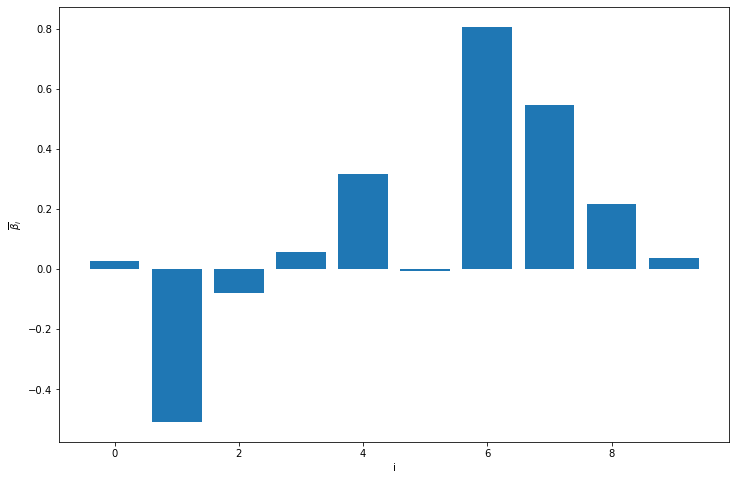

In [55]:
B_freq = res.x

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.bar(np.arange(10), B_freq)
plt.xlabel('i')
plt.ylabel(r'$\overline{\beta}_i$')
plt.show()